# WEO Economic Data Analysis & Recession Prediction

**Objective:** Load World Economic Outlook (WEO) data, clean and transform it, then use machine learning models to predict global recessions.

**Workflow:**
1. Data loading and cleaning
2. Feature engineering and recession flagging
3. Exploratory data analysis
4. Model training with full and reduced feature sets (comparing 13 vs 5 features)
5. Economy-specific analysis (Upper vs Lower economies with both feature sets)
6. Future predictions for all scenarios

**Models Used:** Logistic Regression, Random Forest, Gradient Boosting, Linear SVM, Decision Tree, and Ensemble

In [1]:
#1)Multiclass classification target distribution - aanpassen -done
#2)Threshhold meerdere waardes vullen en dat in Overleaf plaatsen ter discussie -fail
#3)ROC, AUC laten zien -done
#4) Zoek verder op de auteur naar vergelijkbaar werk -wip
#5) Use Arima as baseline -wip
#6) Try neural network -wip

In [2]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import csv
from pathlib import Path

# Machine learning - model selection and preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# Machine learning - metrics
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Optional pycountry for continent mapping
try:
    import pycountry
    import pycountry_convert as pc
    HAS_PYCOUNTRY = True
except ImportError:
    HAS_PYCOUNTRY = False

pd.set_option("display.max_rows", 25)


# 1. Data Loading

In [3]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# Detect encoding and delimiter
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("Shape:", df.shape)
df.head()

Shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [4]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\nColumn names:", df.columns.tolist())

Number of columns: 61
Number of rows: 8626

Column names: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']


# 2. Data Cleaning & Transformation

## Filter to Selected Economic Indicators

In [5]:
df.drop(columns=["WEO Country Code", "ISO", "Country/Series-specific Notes", "Subject Notes", 
                 "Units", "Scale", "Estimates Start After", "Subject Descriptor"], inplace=True)

codes = {
    # Core growth & external
    "NGDP_RPCH", "NGDPRPC", "PCPIPCH", "TX_RPCH", "TM_RPCH", "BCA_NGDPD",
    # Fiscal & debt aggregates
    "GGR_NGDP", "GGX_NGDP", "GGXWDN_NGDP", "GGXWDG_NGDP",
    # Savings & investment
    "NGSD_NGDP", "NID_NGDP",
    # Prices
    "PCPI"
}

col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2548, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
1,NGDP_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.542,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NID_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.987,16.668,15.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,GGR_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.348,16.599,14.649,16.581,18.549,18.698,19.117,19.197,19.277,19.277
8610,GGX_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.573,21.476,19.968,18.641,19.053,18.257,18.231,18.201,18.143,18.110
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8620,GGXWDG_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.172,99.536,96.586,94.587,58.568,56.051,53.294,52.315,50.485,48.312


## Data Reshaping: Wide to Long to Wide

In [6]:
year_cols = df.columns[2:]

df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",
    values="Value",
    aggfunc="first"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,345.977,NaN,6.943,21594.230,NaN,61.151,27.243,31.263,NaN,NaN,NaN
2003,Afghanistan,29.616,9.826,270.602,NaN,11.927,21766.381,8.692,59.718,30.102,42.413,35.663,36.222,49.541
2004,Afghanistan,37.216,12.676,244.967,NaN,15.069,21067.277,0.671,72.570,35.354,49.351,16.358,-0.427,-8.436
2005,Afghanistan,30.226,14.733,206.356,NaN,15.651,22731.779,11.830,67.274,37.048,54.566,10.569,55.010,41.968
2006,Afghanistan,20.844,18.946,22.985,NaN,18.262,22979.189,5.361,50.333,29.489,58.269,6.785,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,56.051,NaN,18.257,6.061,4.640,NaN,NaN,1204688.561,9.627,NaN,NaN
2027,Zimbabwe,2.927,19.117,53.294,NaN,18.231,6.150,3.630,NaN,NaN,1300690.916,7.969,NaN,NaN
2028,Zimbabwe,2.895,19.197,52.315,NaN,18.201,6.231,3.458,NaN,NaN,1404343.758,7.969,NaN,NaN


# 3. Feature Engineering

## Add Recession Target Variable

In [7]:
# --- Step 1: IMF-recognized global recession years ---
global_recession_years = [1982, 1991, 2009, 2020]

# --- Step 2: Ensure chronological order ---
df_pivot = df_pivot.sort_index()

# --- Step 3: Construct diagnostic flags (not stored in df) ---

# GDP-based recession (two consecutive annual declines)
flag_gdp = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

# Investment collapse
flag_invest = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# Savings decline
flag_savings = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# Trade shock
flag_trade = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

# Inflation shock
flag_inflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

# --- Step 3: Combine signals into a single severity score ---
local_signal_count = (
    flag_gdp + flag_invest + flag_savings + flag_trade + flag_inflation
)

# Global recession override
global_recession = df_pivot.index.isin(global_recession_years).astype(int)

# --- Step 4: Multiclass recession risk label ---
def classify_risk(global_flag, local_count):
    if global_flag == 1:
        return 3  # High risk
    if local_count >= 3:
        return 3  # High risk
    if local_count == 2:
        return 2  # Moderate risk
    if local_count == 1:
        return 1  # Mild risk
    return 0      # No risk

df_pivot["RecessionRisk"] = [
    classify_risk(g, l) for g, l in zip(global_recession, local_signal_count)
]

# --- Step 5: Clean dataset ---
df_pivot = df_pivot.dropna().sort_index(ascending=True)

# --- Output: only the multiclass label ---
df_pivot


C:\Users\ningw\AppData\Local\Temp\ipykernel_31508\1462810173.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
C:\Users\ningw\AppData\Local\Temp\ipykernel_31508\1462810173.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
C:\Users\ningw\AppData\Local\Temp\ipykernel_31508\1462810173.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,21732.461,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2341283.427,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,18811.646,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,529775.630,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,36526.988,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,South_Africa,-2.191,27.585,88.732,87.354,33.225,73913.430,1.812,11.975,14.166,128.458,4.500,3.308,3.405,0
2030,Spain,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,0
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354,0


## Review Remaining Countries

In [8]:
df_pivot["Country"].unique()

array(['Finland', 'Japan', 'United_Kingdom', 'Norway', 'Canada',
       'Iceland', 'France', 'Spain', 'New_Zealand', 'Italy', 'Jordan',
       'Australia', 'Syria', 'Oman', 'Switzerland', 'Saudi_Arabia',
       'Algeria', 'Chile', 'Ethiopia', 'Sweden', 'Namibia', 'Barbados',
       'Panama', 'Netherlands', 'Slovenia', 'Portugal', 'Denmark',
       'Cyprus', 'Niger', 'Germany', 'Islamic_Republic_of_Iran', 'Poland',
       'Morocco', 'Estonia', 'Cabo_Verde', 'Guyana',
       'Taiwan_Province_of_China', 'Lithuania', 'Kenya', 'Ireland',
       'Belgium', 'Mexico', 'Austria', 'Yemen', 'Czech_Republic',
       'Bosnia_and_Herzegovina', 'Slovak_Republic', 'Colombia', 'Egypt',
       'Latvia', 'Equatorial_Guinea', 'Cameroon', 'Hungary', 'Bulgaria',
       'South_Africa', 'Botswana', 'Lesotho', 'Paraguay', 'Bolivia',
       'Peru', 'Croatia', 'Romania', 'Türkiye', 'Dominican_Republic',
       'Zambia', 'Mali', 'Israel', 'Seychelles', 'Brazil', 'Malta',
       'Pakistan', 'Eswatini', 'Serbia', '

## Split Training and Prediction Data

In [9]:
df_filtered = df_pivot.loc[df_pivot.index <= 2025]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,2.173246e+04,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2.341283e+06,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,1.881165e+04,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,5.297756e+05,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,3.652699e+04,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,Sweden,6.761,47.659,33.727,12.127,49.106,5.984427e+05,1.858,31.683,24.922,131.713,2.112,2.403,2.452,0
2025,Chile,-2.062,24.640,42.984,26.865,26.648,1.060001e+07,2.032,21.279,23.339,143.476,4.363,3.663,3.618,0
2025,Korea,3.500,22.921,54.453,9.297,23.324,4.473910e+07,1.027,35.046,31.546,116.280,1.839,1.697,1.494,0


# 4. Exploratory Data Analysis

## Correlation Heatmap

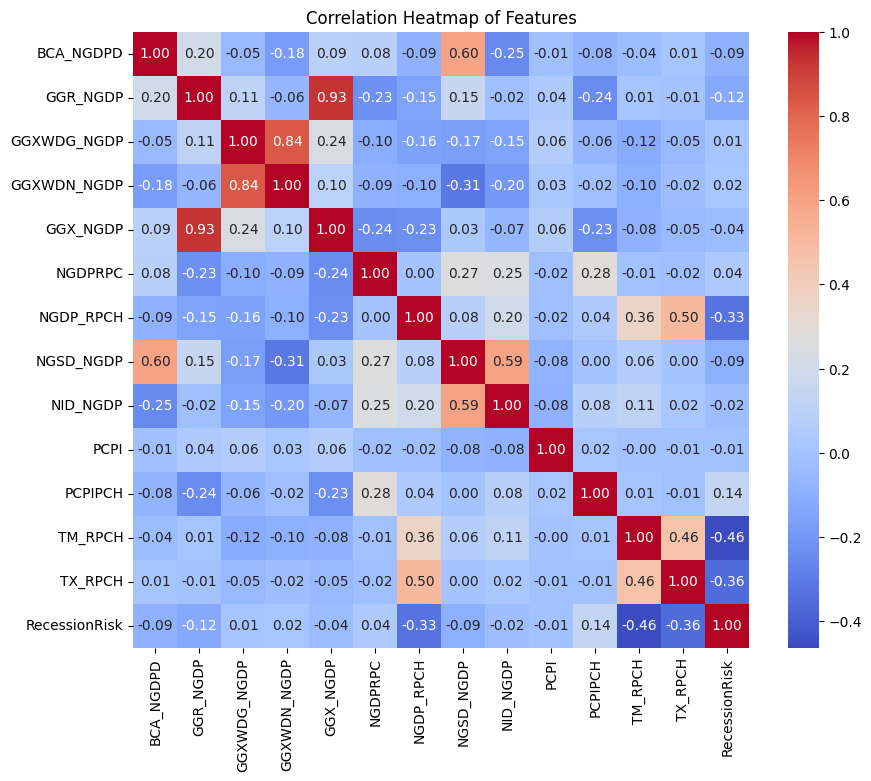

In [10]:
corr = df_filtered.drop(columns=["Country"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

## Prepare Features and Target

In [11]:
X = df_filtered.drop(columns=["RecessionRisk", "Country"])
y = df_filtered["RecessionRisk"]

# 5. Machine Learning Models

## Global Dataset - Full Features (13 Features)

### Define and Train All Models

In [12]:
# ============================================================
#             TRAIN ALL MODELS (MULTICLASS)
# ============================================================
def train_all_models(X_train, y_train, X_test, y_test, model_params=None, use_xgb=False):

    if model_params is None:
        model_params = {
            'logit': {
                'C': 0.2,
                'penalty': 'l2',
                'solver': 'lbfgs',
                'max_iter': 5000,
                'random_state': 42,
                'multi_class': 'multinomial'
            },
            'rf': {
                'n_estimators': 200,
                'max_depth': 4,
                'min_samples_leaf': 20,
                'min_samples_split': 20,
                'max_features': 0.3,
                'random_state': 42
            },
            'gb': {
                'n_estimators': 200,
                'learning_rate': 0.03,
                'max_depth': 2,
                'min_samples_leaf': 20,
                'subsample': 0.6,
                'random_state': 42
            },
            'dt': {
                'max_depth': 3,
                'min_samples_leaf': 30,
                'random_state': 42
            },
            'svm': {
                'C': 1.0,
                'kernel': 'rbf',
                'probability': True,
                'random_state': 42,
                'decision_function_shape': 'ovr'
            },
            'xgb': {
                'n_estimators': 200,
                'learning_rate': 0.05,
                'max_depth': 2,
                'subsample': 0.7,
                'colsample_bytree': 0.6,
                'reg_alpha': 0.4,
                'reg_lambda': 2.0,
                'random_state': 42,
                'objective': 'multi:softprob',
                'num_class': len(np.unique(y_train))
            }
        }

    # ----------------- Train models -----------------
    logit = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("logit", LogisticRegression(**model_params['logit']))
    ]).fit(X_train, y_train)

    rf = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(**model_params['rf']))
    ]).fit(X_train, y_train)

    gb = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("gb", GradientBoostingClassifier(**model_params['gb']))
    ]).fit(X_train, y_train)

    dt = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("dt", DecisionTreeClassifier(**model_params['dt']))
    ]).fit(X_train, y_train)

    svm = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("svm", SVC(**model_params['svm']))
    ]).fit(X_train, y_train)

    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Decision Tree": dt,
        "SVM": svm,
    }

    if use_xgb:
        xgb = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("xgb", XGBClassifier(**model_params['xgb']))
        ]).fit(X_train, y_train)
        models["XGBoost"] = xgb

    # ----------------- Ensemble -----------------
    ensemble_estimators = [
        ("logit", logit.named_steps["logit"]),
        ("rf", rf.named_steps["rf"]),
        ("gb", gb.named_steps["gb"]),
        ("svm", svm.named_steps["svm"])
    ]
    if use_xgb:
        ensemble_estimators.append(("xgb", xgb.named_steps["xgb"]))

    ensemble = VotingClassifier(estimators=ensemble_estimators, voting="soft")
    ensemble.fit(X_train, y_train)
    models["Ensemble"] = ensemble

    # ----------------- Metrics -----------------
    results = {}
    confusion_mats = {}

    for name, m in models.items():
        y_pred_train = m.predict(X_train)
        y_pred_test = m.predict(X_test)

        results[name] = {
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision (macro)": precision_score(y_test, y_pred_test, average="macro", zero_division=0),
            "Recall (macro)": recall_score(y_test, y_pred_test, average="macro", zero_division=0),
            "F1 (macro)": f1_score(y_test, y_pred_test, average="macro", zero_division=0)
        }

        confusion_mats[name] = confusion_matrix(y_test, y_pred_test)

    results_df = pd.DataFrame(results).T
    return models, results_df, confusion_mats


# ============================================================
#             FEATURE IMPORTANCE (MULTICLASS)
# ============================================================
def plot_feature_importance(models, feature_names, title_prefix=""):

    logit = models.get("Logistic Regression")
    rf = models.get("Random Forest")
    gb = models.get("Gradient Boosting")
    dt = models.get("Decision Tree")

    coef_matrix = logit.named_steps['logit'].coef_
    coef_mean_abs = np.mean(np.abs(coef_matrix), axis=0)

    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": coef_mean_abs
    }).sort_values("Importance")

    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.named_steps['rf'].feature_importances_
    }).sort_values("Importance")

    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.named_steps['gb'].feature_importances_
    }).sort_values("Importance")

    dt_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": dt.named_steps['dt'].feature_importances_
    }).sort_values("Importance")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    axes[0, 0].barh(logit_importance["Feature"], logit_importance["Importance"])
    axes[0, 0].set_title(f"{title_prefix}Logistic Regression")

    axes[0, 1].barh(rf_importance["Feature"], rf_importance["Importance"])
    axes[0, 1].set_title(f"{title_prefix}Random Forest")

    axes[1, 0].barh(gb_importance["Feature"], gb_importance["Importance"])
    axes[1, 0].set_title(f"{title_prefix}Gradient Boosting")

    axes[1, 1].barh(dt_importance["Feature"], dt_importance["Importance"])
    axes[1, 1].set_title(f"{title_prefix}Decision Tree")

    plt.tight_layout()
    plt.show()


# ============================================================
#             CONFUSION MATRIX DISPLAY (MULTICLASS)
# ============================================================
def show_confusion_matrices(confusion_mats, results_df):

    n_models = len(confusion_mats)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (name, cm) in zip(axes, confusion_mats.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", ax=ax, colorbar=False)

        acc = results_df.loc[name, "Test Accuracy"]
        prec = results_df.loc[name, "Precision (macro)"]
        rec = results_df.loc[name, "Recall (macro)"]
        f1 = results_df.loc[name, "F1 (macro)"]

        ax.set_title(
            f"{name}\nAcc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}, F1={f1:.2f}",
            fontsize=11
        )

    plt.tight_layout()
    plt.show()

# ============================================================
#             ROC CURVES + MACRO AUC (MULTICLASS)
# ============================================================
def show_roc_curves(models, X_test, y_test):
    """
    Display ROC curves and macro AUC for all models.
    Works for multiclass classification.
    """

    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    classes = sorted(np.unique(y_test))

    for ax, (name, model) in zip(axes, models.items()):

        if not hasattr(model, "predict_proba"):
            ax.set_title(f"{name}\n(No predict_proba)")
            ax.axis("off")
            continue

        # Predict probabilities
        y_proba = model.predict_proba(X_test)

        aucs = []
        for c in classes:
            y_true_bin = (y_test == c).astype(int)
            y_score = y_proba[:, c]

            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)

            ax.plot(fpr, tpr, label=f"Class {c} (AUC={auc_val:.2f})")

        macro_auc = np.mean(aucs)

        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"{name}\nMacro AUC={macro_auc:.2f}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()

    plt.tight_layout()
    plt.show()


In [13]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Training the model 

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.558435       0.527383           0.477515   
Random Forest              0.704776       0.630832           0.538157   
Gradient Boosting          0.716463       0.592292           0.547949   
Decision Tree              0.622967       0.527383           0.475458   
SVM                        0.733740       0.567951           0.498783   
Ensemble                   0.707825       0.620690           0.469088   

                     Recall (macro)  F1 (macro)  
Logistic Regression        0.522495    0.481770  
Random Forest              0.563651    0.532969  
Gradient Boosting          0.565341    0.535183  
Decision Tree              0.481604    0.443763  
SVM                        0.519690    0.501766  
Ensemble                   0.410060    0.388609  


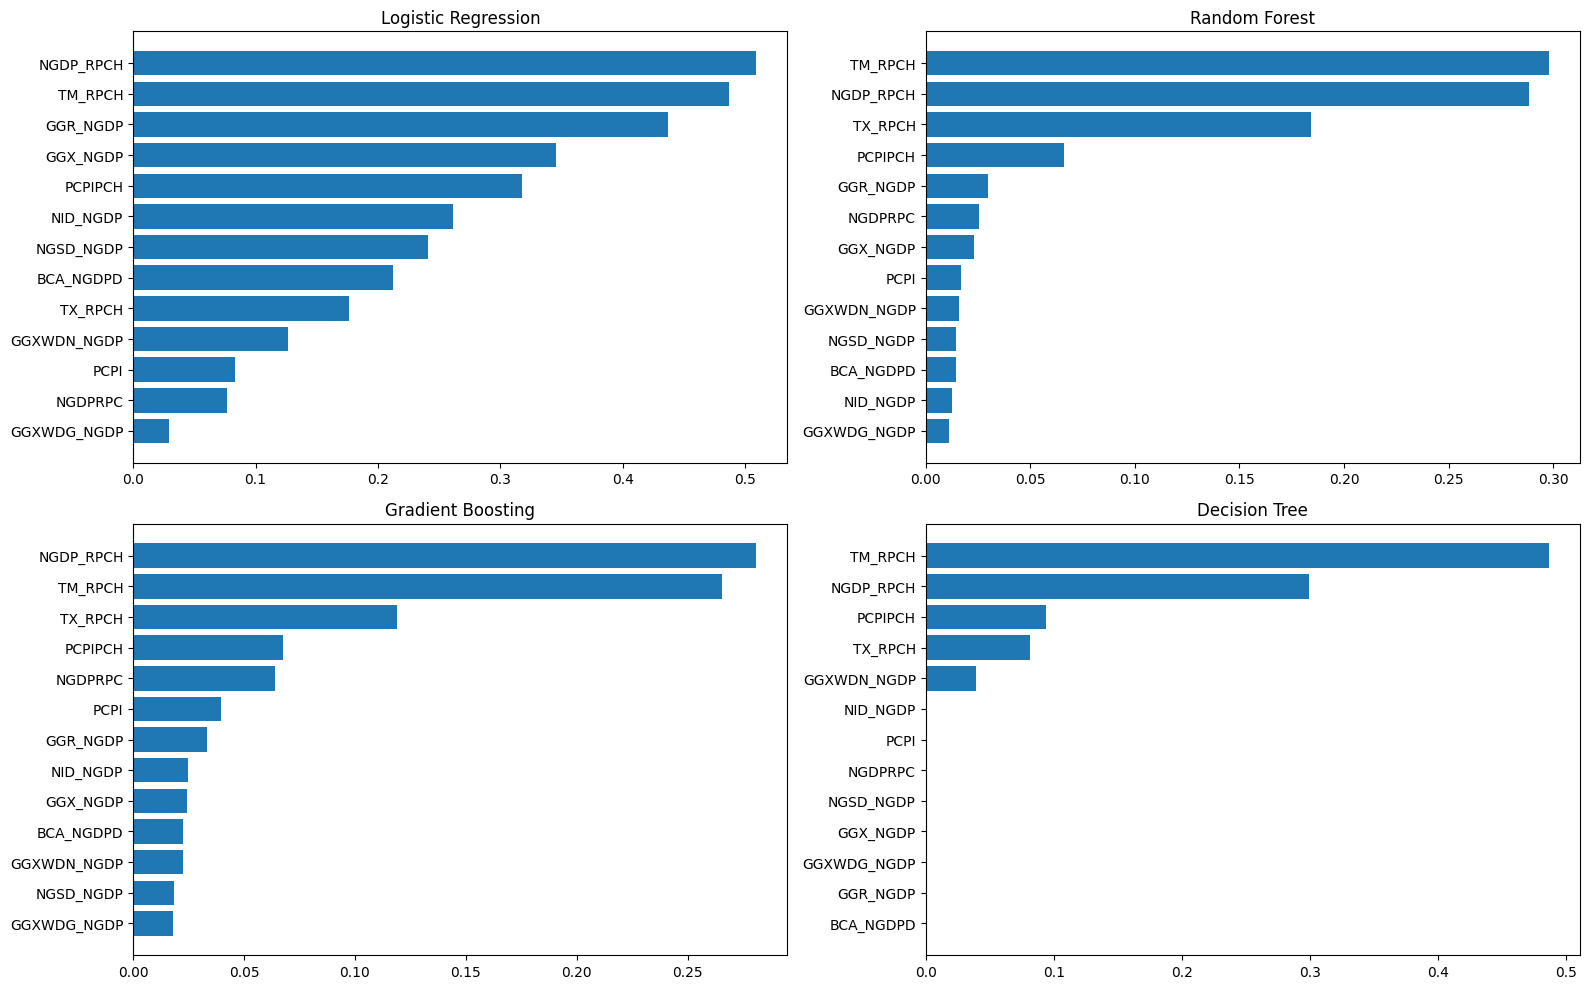

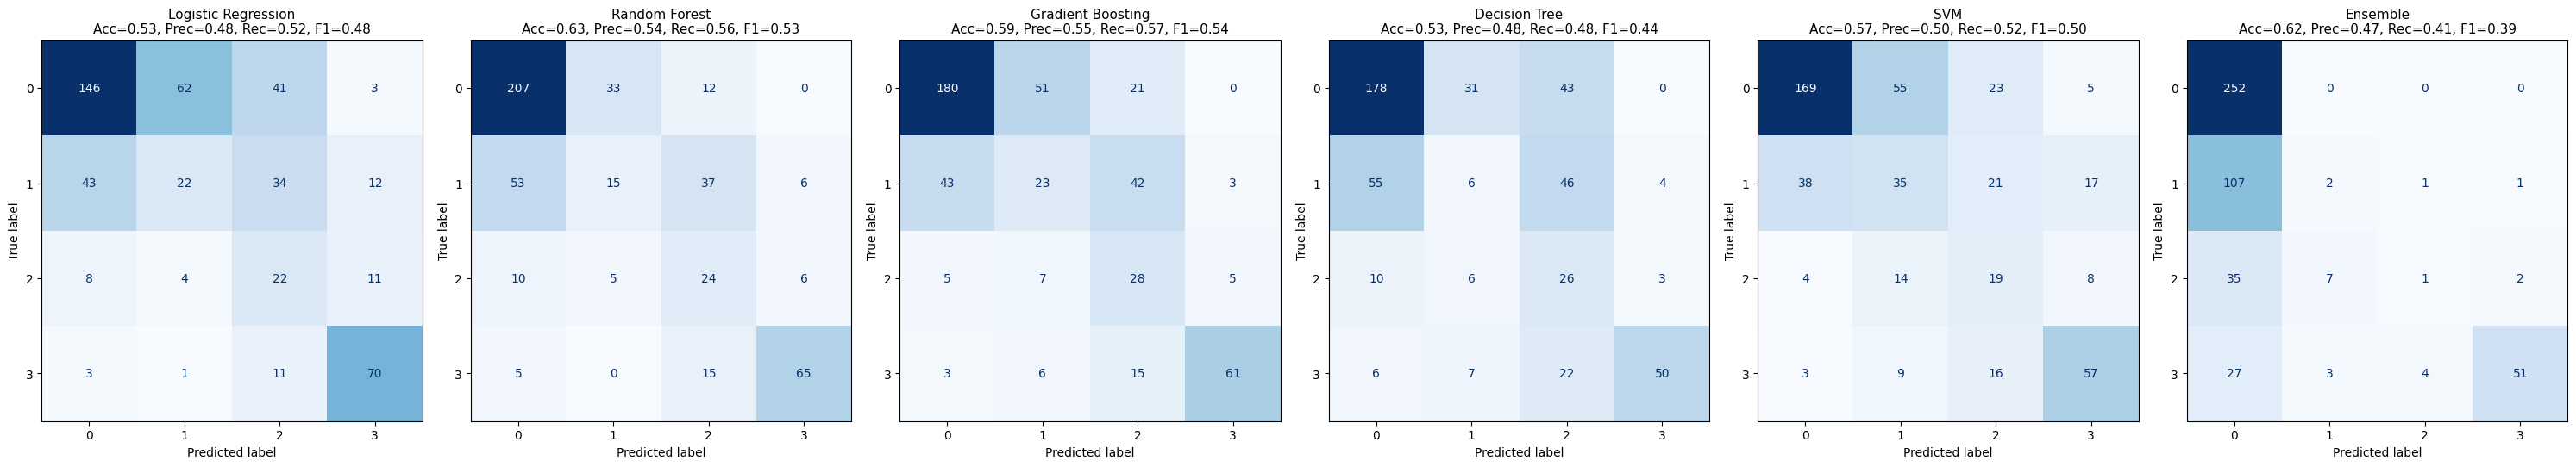

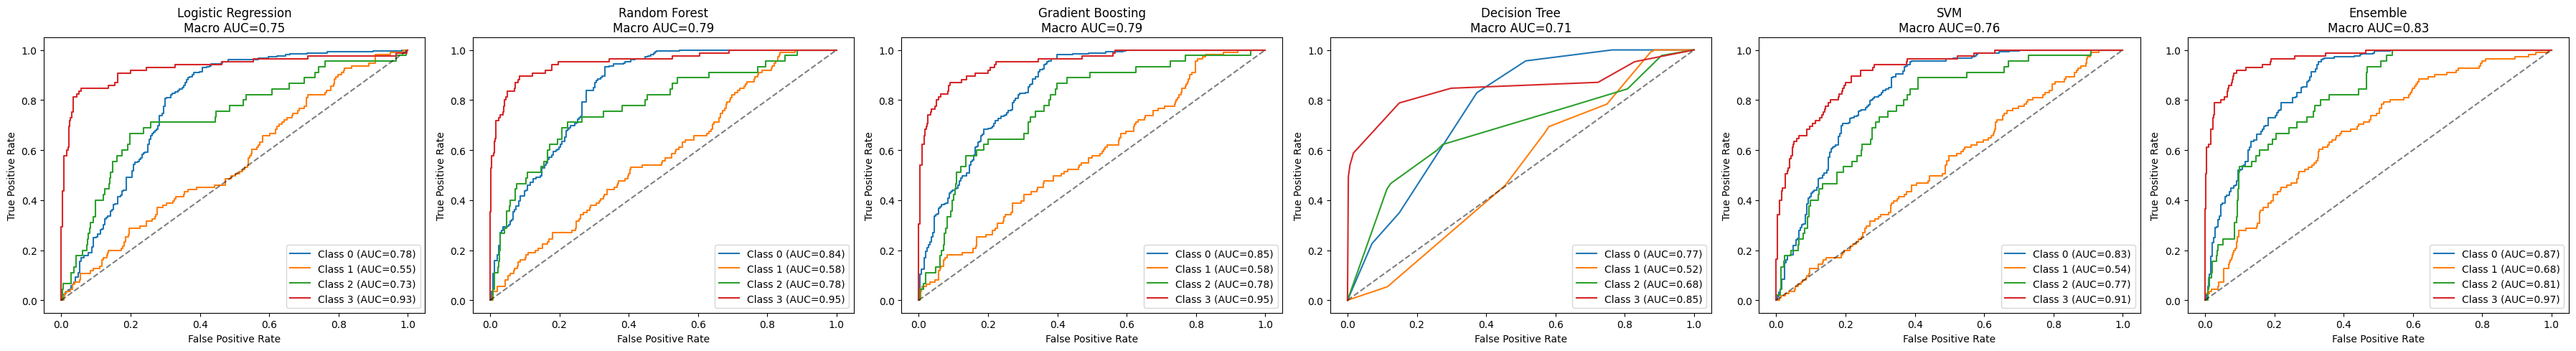

In [14]:
models, summary_df, confusion_mats = train_all_models(X_train, y_train, X_test, y_test)

print(summary_df)
plot_feature_importance(models, X_train.columns.tolist())
# Show confusion matrices with metrics underneath
show_confusion_matrices(confusion_mats, summary_df)
show_roc_curves(models, X_test, y_test)


### Reduced Global Set

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.566057       0.511156           0.473125   
Random Forest              0.695630       0.632860           0.529780   
Gradient Boosting          0.692581       0.596349           0.537235   
Decision Tree              0.624492       0.523327           0.489521   
SVM                        0.708333       0.598377           0.564386   
Ensemble                   0.714431       0.651116           0.643539   

                     Recall (macro)  F1 (macro)  
Logistic Regression        0.528844    0.483408  
Random Forest              0.559821    0.535556  
Gradient Boosting          0.561031    0.540621  
Decision Tree              0.479690    0.437088  
SVM                        0.580260    0.559651  
Ensemble                   0.456533    0.448048  


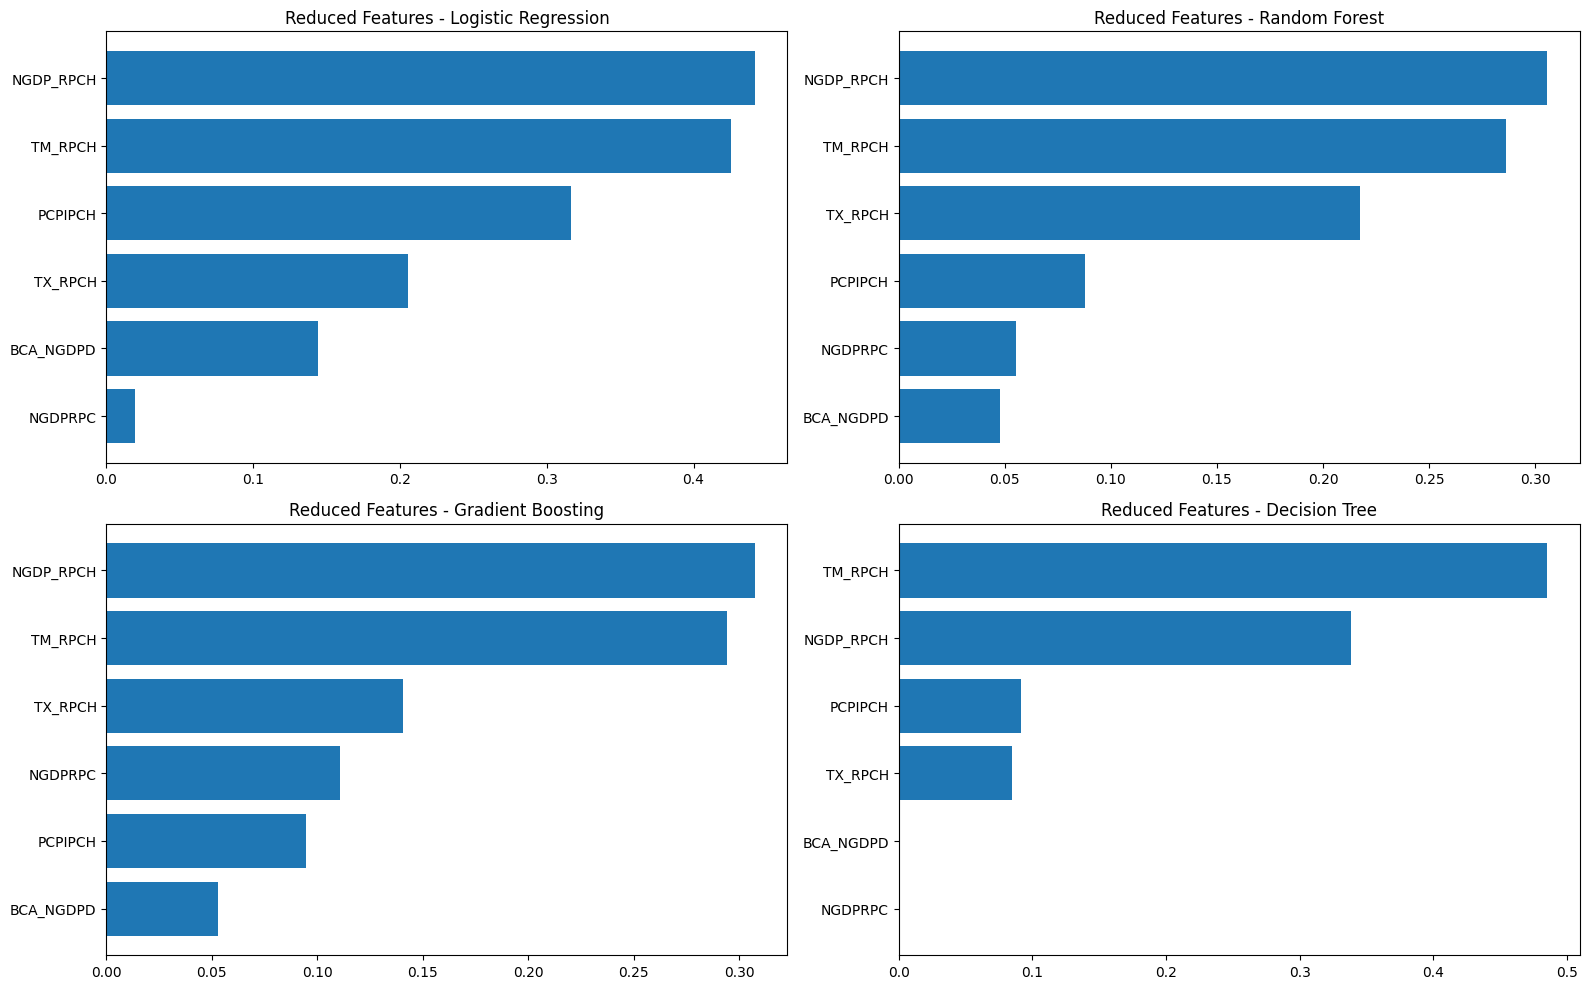

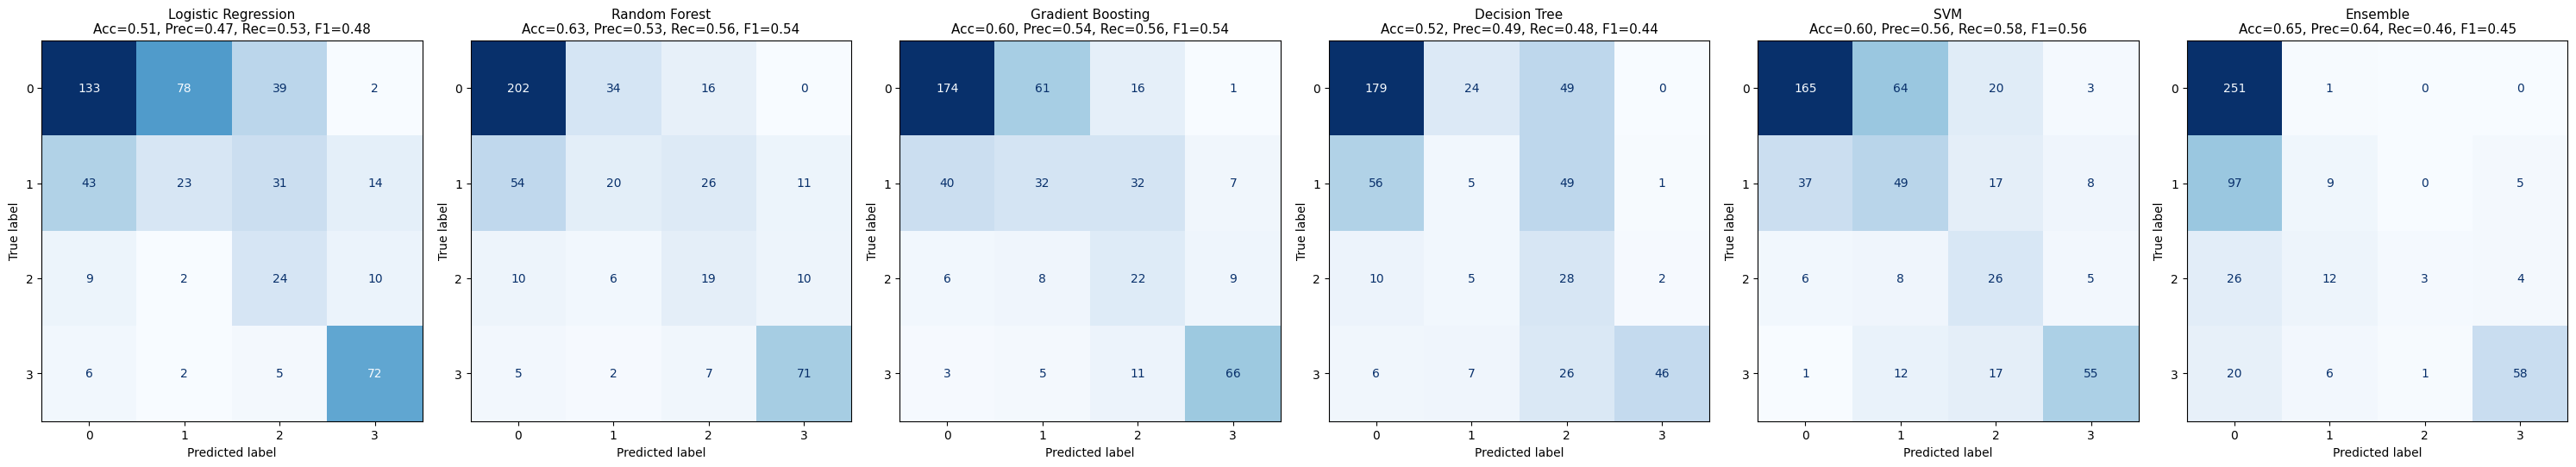

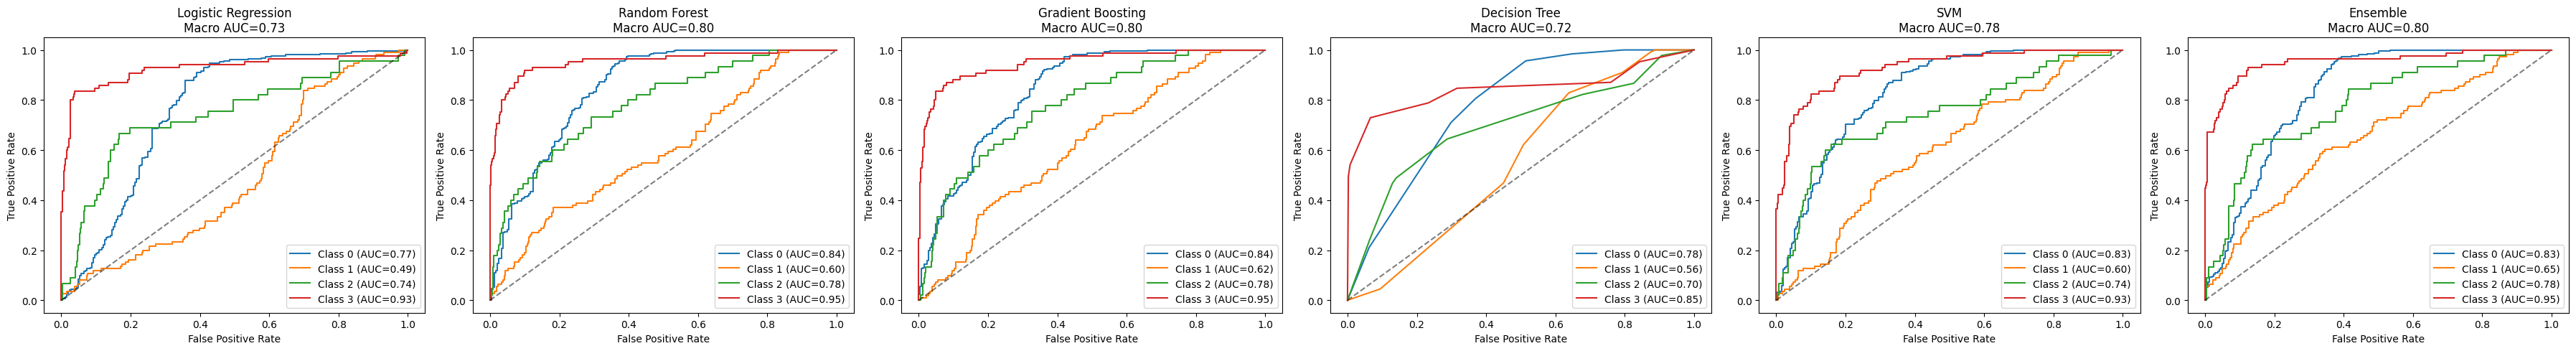

In [15]:
selected_features = ['TM_RPCH', 'NGDP_RPCH', 'TX_RPCH', 'PCPIPCH', 'BCA_NGDPD', 'NGDPRPC']
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Unpack all three return values
models_reduced, summary_df_reduced, confusion_mats_reduced = train_all_models(
    X_train_reduced, y_train, X_test_reduced, y_test
)

# Show metrics table
print(summary_df_reduced)
# Plot feature importance
plot_feature_importance(models_reduced, feature_names=selected_features, title_prefix="Reduced Features - ")

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_reduced, summary_df_reduced)
show_roc_curves(models_reduced, X_test_reduced, y_test)


### Split Dataset

In [16]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
    'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
    'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
    'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
    'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
    'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
    'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
    'Australia': 'Oceania', 'New_Zealand': 'Oceania',
    'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
    'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',

    'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
    'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
    'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
    'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
    'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
    'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
    'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
    'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
    'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
    'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
    'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
    'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
    'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
    'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
    'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America',
    'Botswana': 'Africa', 'Cameroon': 'Africa', 'Djibouti': 'Africa', 'Equatorial_Guinea': 'Africa',
    'Eswatini': 'Africa','Guyana': 'South_America','Lesotho': 'Africa','Mali': 'Africa',
    'Mauritania': 'Africa','Namibia': 'Africa','Niger': 'Africa','Oman': 'Asia','Yemen': 'Asia',
    'Zambia': 'Africa','St._Kitts_and_Nevis': 'North_America'
}

    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("Created economy-specific DataFrames:")
print(f" - Lower_Economies: df_Lower_Economies (rows: {len(df_Lower_Economies)})")
print(f" - Upper_Economies: df_Upper_Economies (rows: {len(df_Upper_Economies)})")


Created economy-specific DataFrames:
 - Lower_Economies: df_Lower_Economies (rows: 1302)
 - Upper_Economies: df_Upper_Economies (rows: 1569)


# 6. Economy-Specific Analysis

## Upper Economies - Full Features

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown i

                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.618327       0.477707           0.313948   
Random Forest              0.771315       0.792994           0.557263   
Gradient Boosting          0.779283       0.738854           0.547439   
Decision Tree              0.538645       0.656051           0.323227   
SVM                        0.795219       0.608280           0.330495   
Ensemble                   0.782470       0.923567           0.731511   

                     Recall (macro)  F1 (macro)  
Logistic Regression        0.522387    0.283257  
Random Forest              0.653052    0.573536  
Gradient Boosting          0.609786    0.549441  
Decision Tree              0.444262    0.325876  
SVM                        0.676444    0.342838  
Ensemble                   0.541667    0.561829  


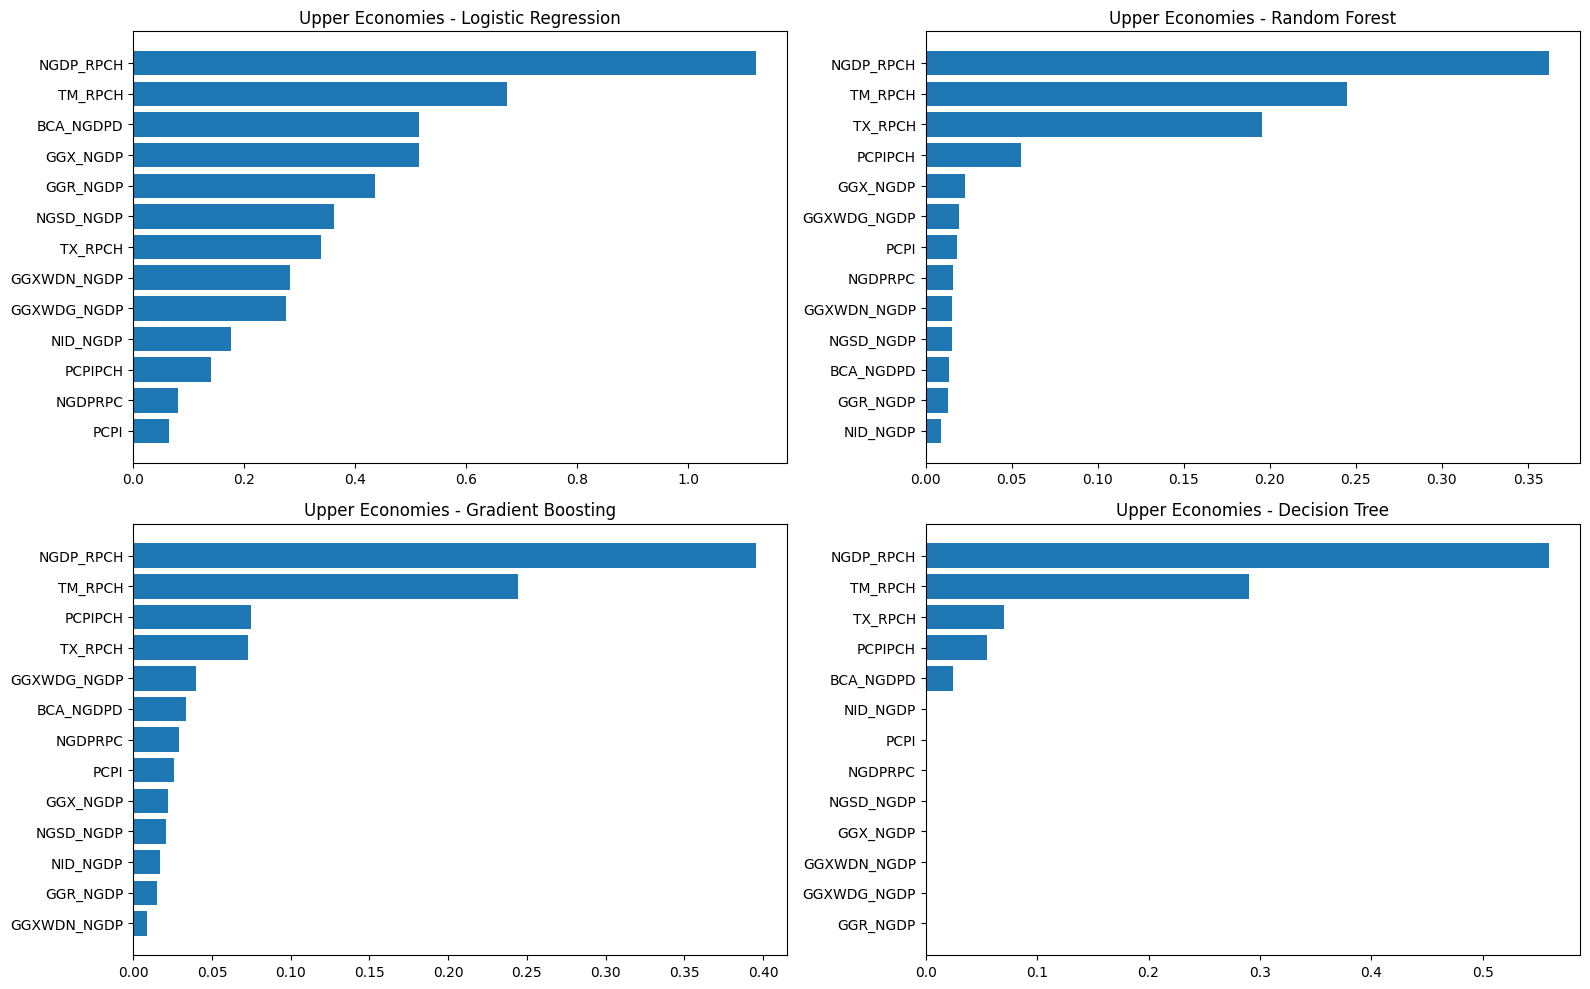

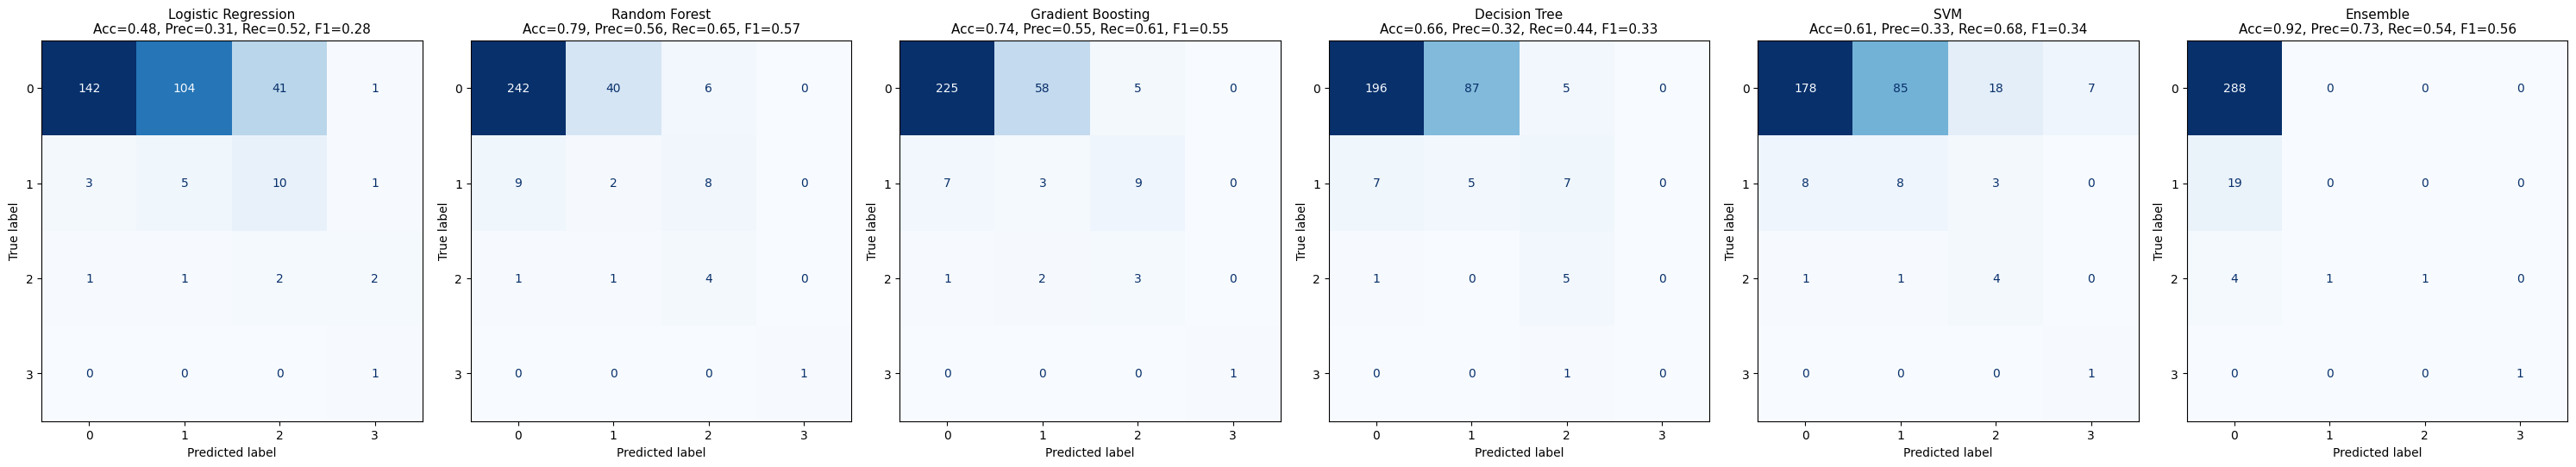

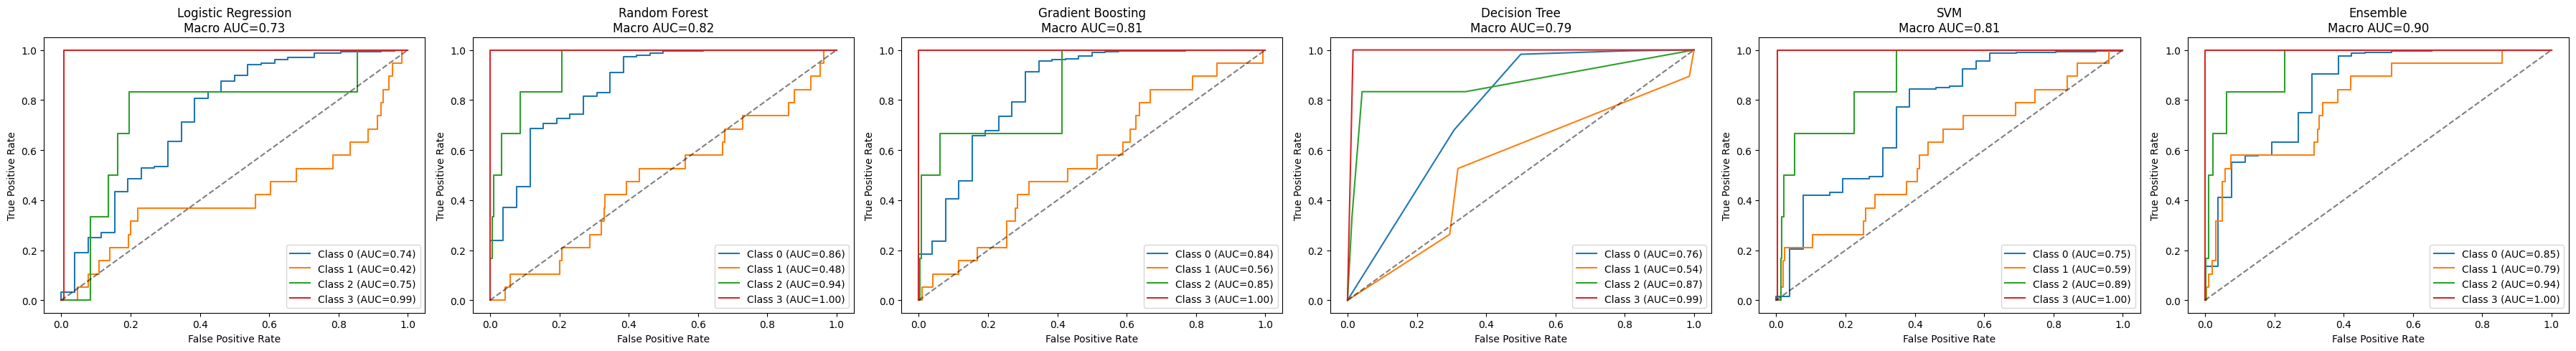

In [17]:
# Prepare data
X = df_Upper_Economies.drop(columns=["RecessionRisk", "Country"])
y = df_Upper_Economies["RecessionRisk"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train, y_train, X_test, y_test
)

# Show metrics table
print(summary_df_upper)

# Plot feature importance
plot_feature_importance(models_upper, X_train.columns.tolist(), title_prefix="Upper Economies - ")

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, summary_df_upper)
# ✅ Show ROC curves + AUC for upper-economy models
show_roc_curves(models_upper, X_test, y_test)

## Lower Economies - Full Features

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.500480       0.490421           0.304675   
Random Forest              0.658982       0.827586           0.391495   
Gradient Boosting          0.703170       0.704981           0.399502   
Decision Tree              0.537944       0.701149           0.301890   
SVM                        0.681076       0.666667           0.338312   
Ensemble                   0.653218       0.877395           0.554563   

                     Recall (macro)  F1 (macro)  
Logistic Regression        0.441511    0.277439  
Random Forest              0.483500    0.410178  
Gradient Boosting          0.552336    0.432994  
Decision Tree              0.368460    0.302365  
SVM                        0.526126    0.362564  
Ensemble                   0.451149    0.458546  


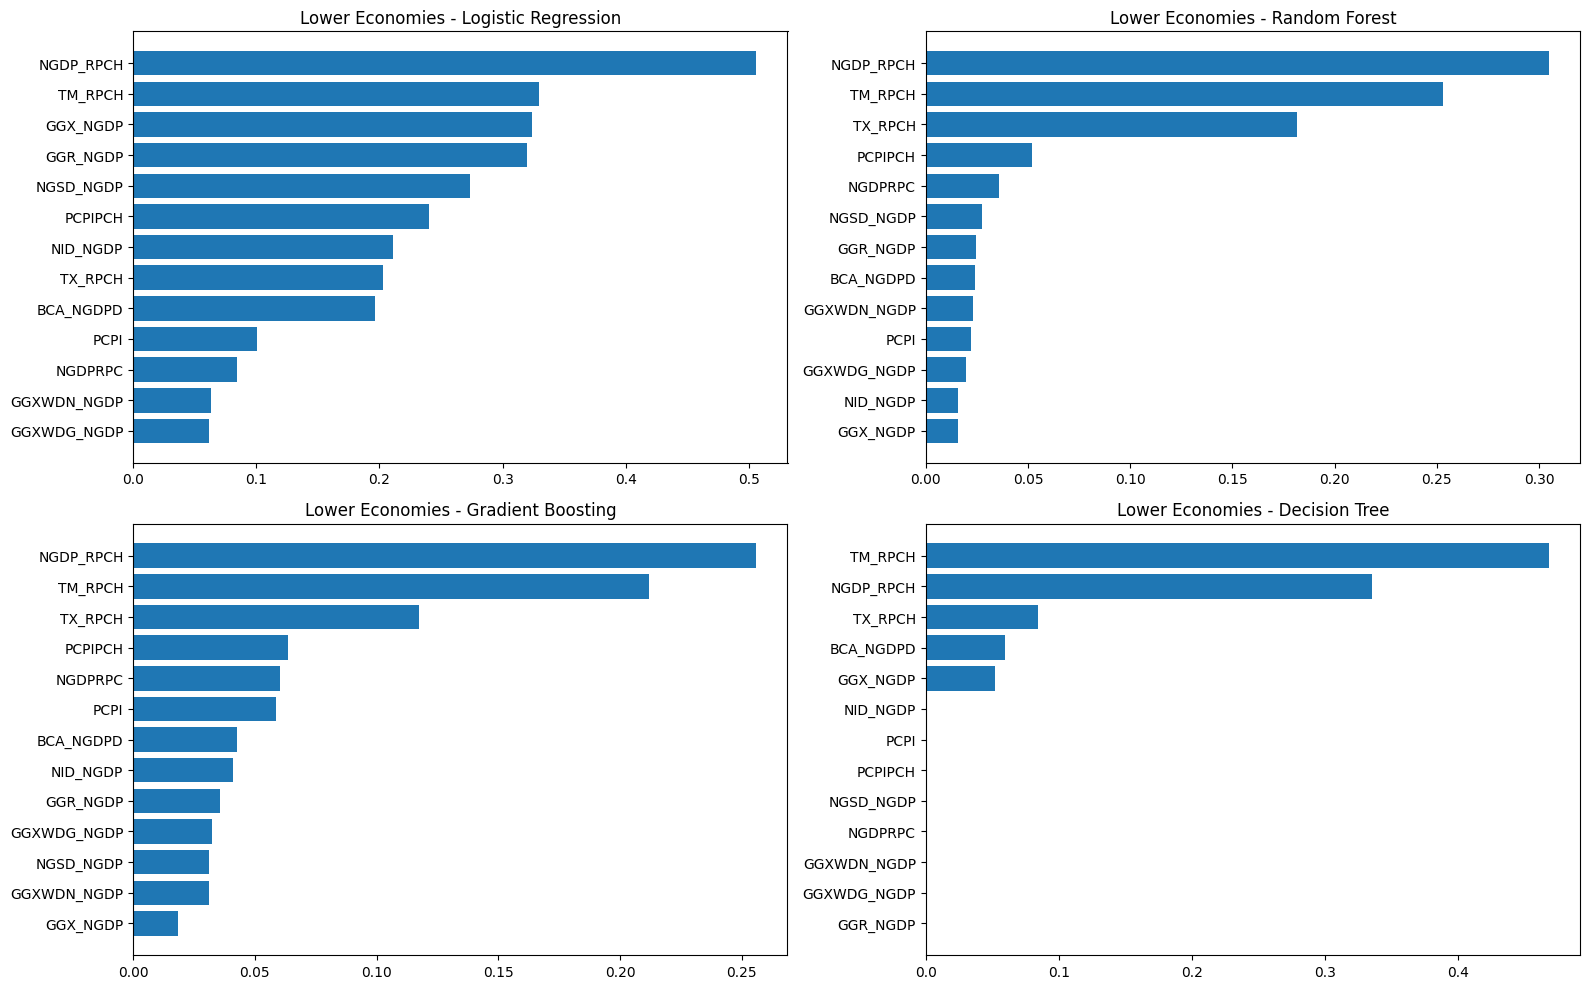

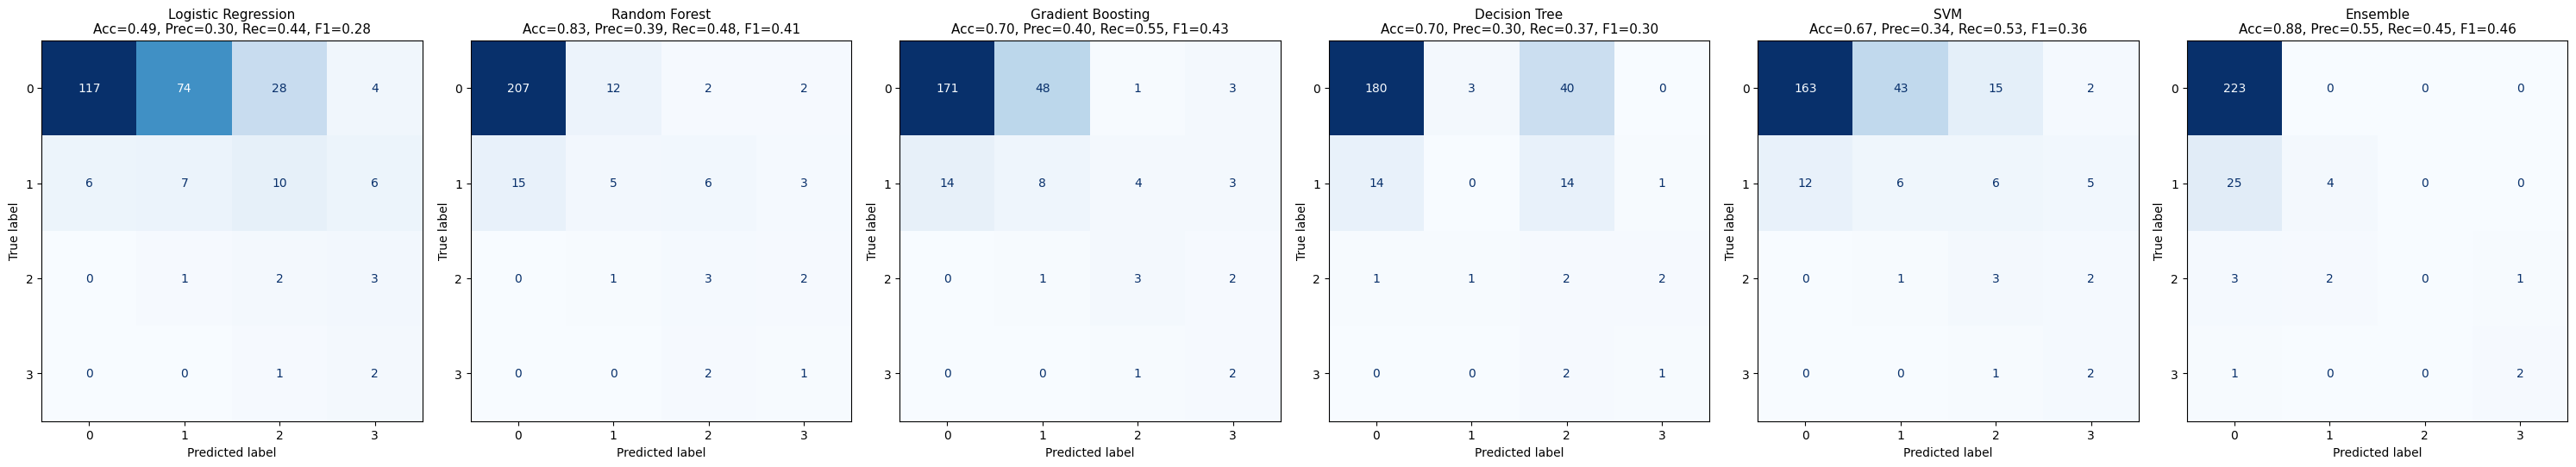

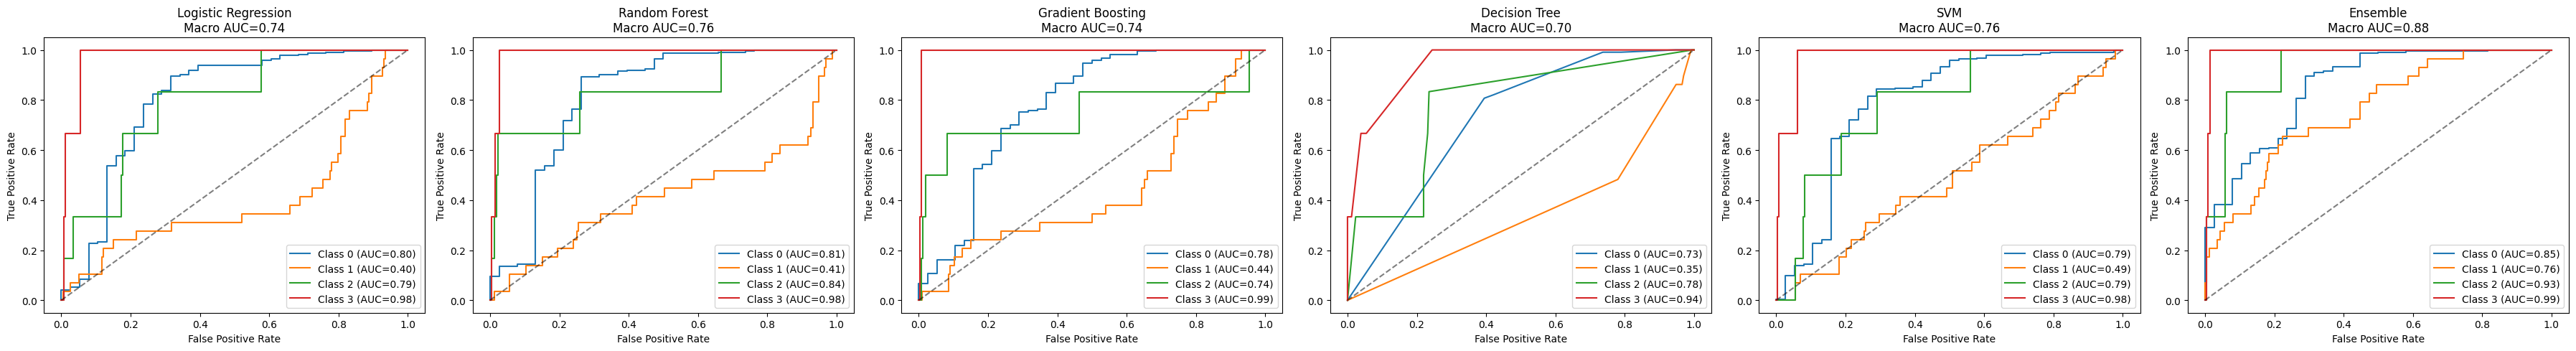

In [18]:
# Prepare data for Lower Economies
X = df_Lower_Economies.drop(columns=["RecessionRisk", "Country"])
y = df_Lower_Economies["RecessionRisk"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train, y_train, X_test, y_test
)

# Show metrics table
print(summary_df_lower)

# Plot feature importance
plot_feature_importance(models_lower, X_train.columns.tolist(), title_prefix="Lower Economies - ")


# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, summary_df_lower)
# ✅ Show ROC curves + AUC for lower-economy models
show_roc_curves(models_lower, X_test, y_test)

## Upper Economies - Reduced Features

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown i

Upper Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.609562       0.222930           0.396101   
Random Forest              0.764143       0.792994           0.557625   
Gradient Boosting          0.754582       0.681529           0.559903   
Decision Tree              0.538645       0.656051           0.323227   
SVM                        0.771315       0.614650           0.304792   
Ensemble                   0.782470       0.929936           0.732258   

                     Recall (macro)  F1 (macro)  
Logistic Regression        0.506031    0.312678  
Random Forest              0.624543    0.568724  
Gradient Boosting          0.631031    0.554285  
Decision Tree              0.444262    0.325876  
SVM                        0.412829    0.287130  
Ensemble                   0.539474    0.558984  


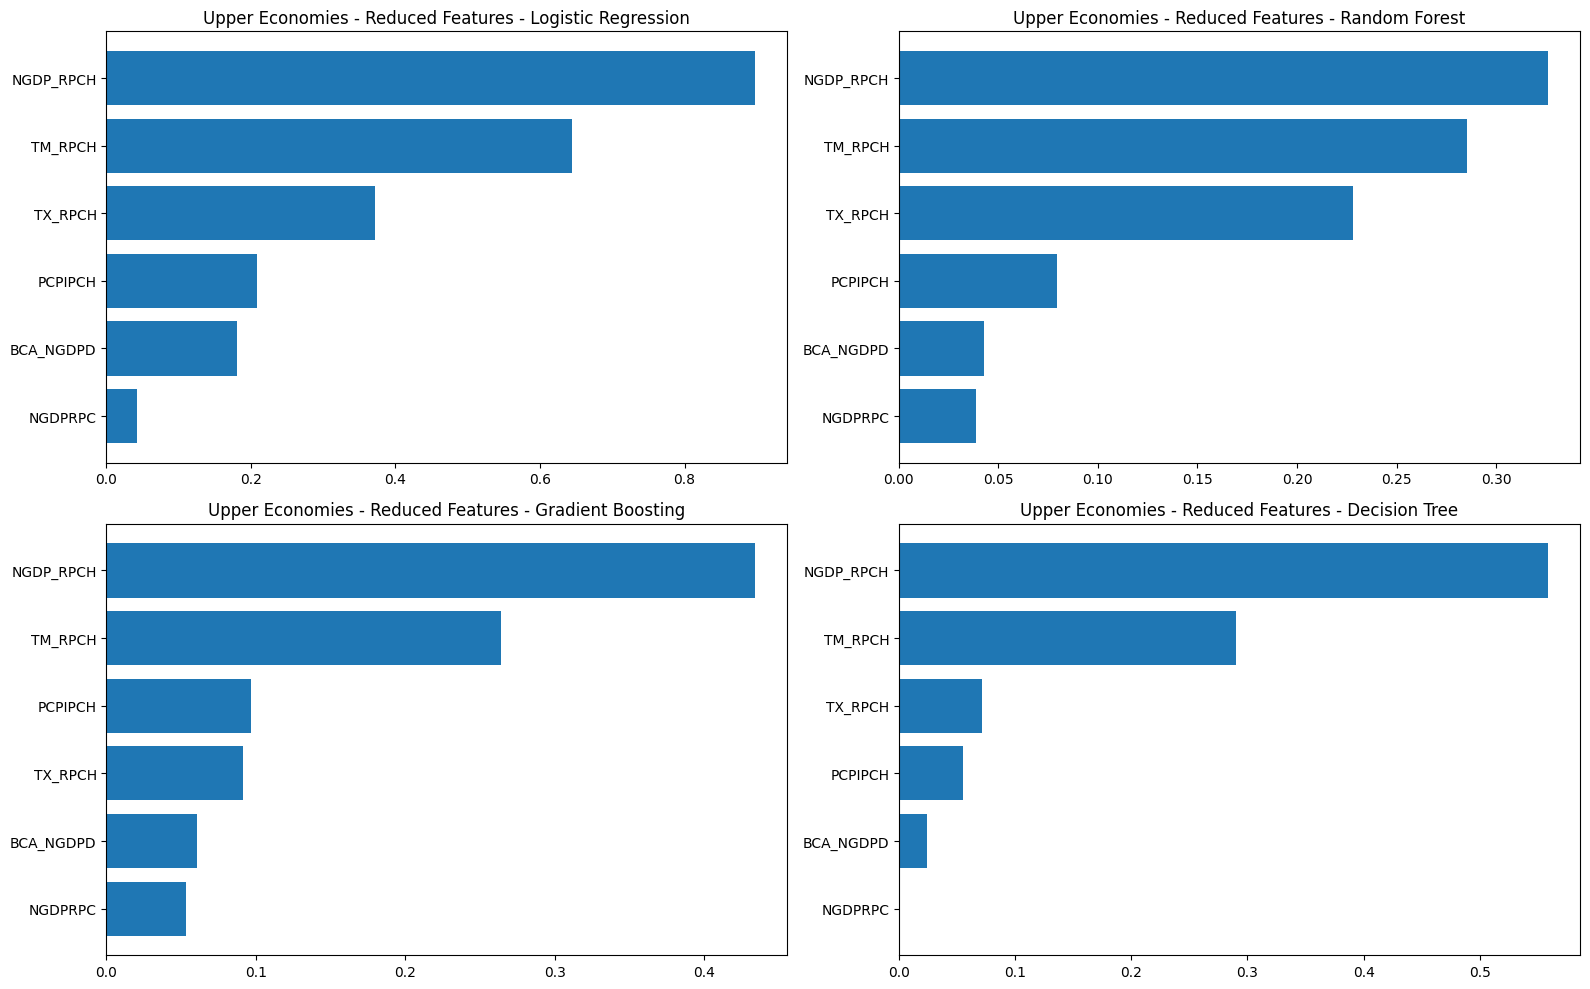

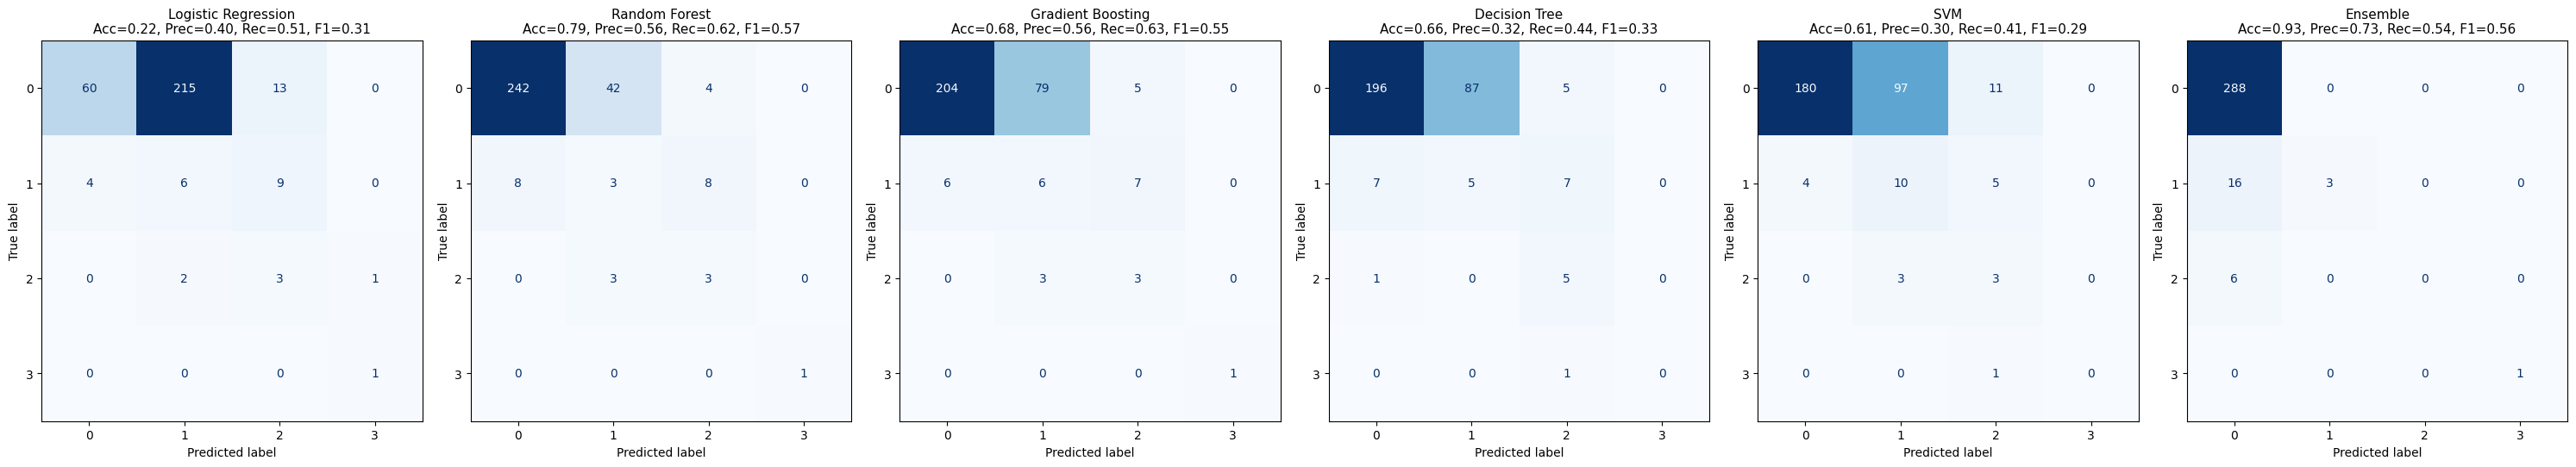

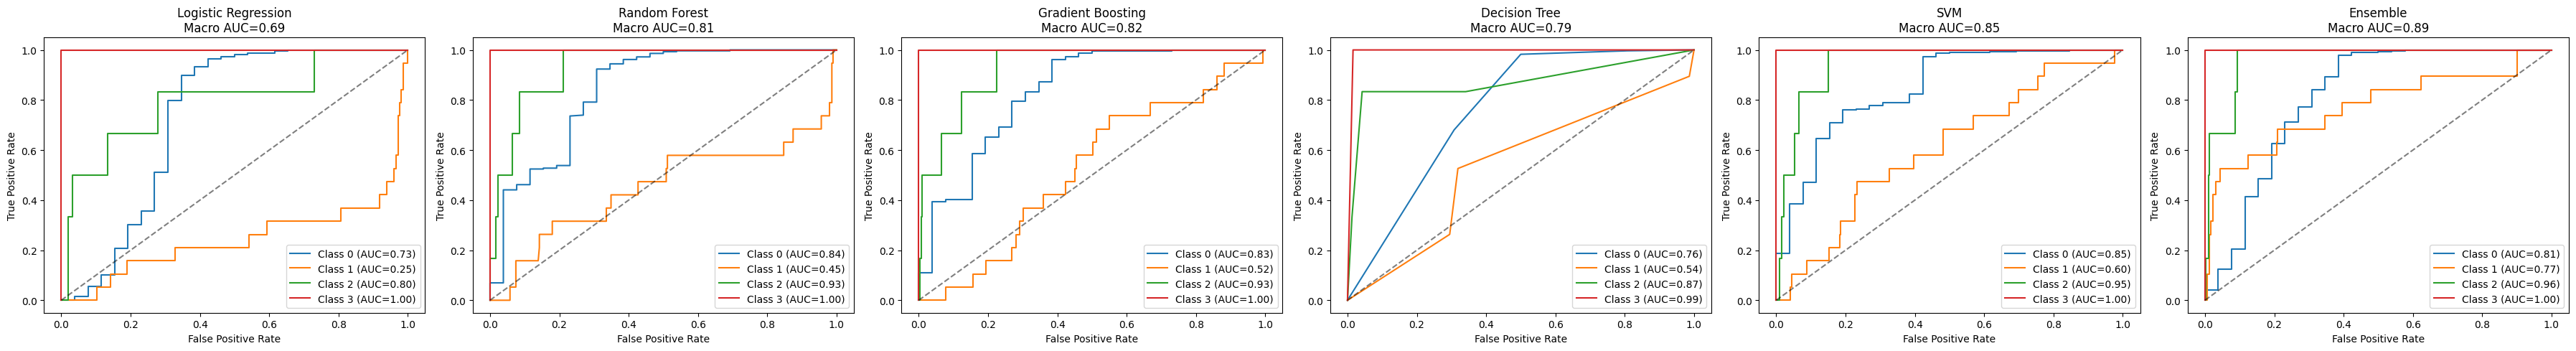

In [19]:
X_upper = df_Upper_Economies[selected_features]
y_upper = df_Upper_Economies["RecessionRisk"]

split_index_upper = int(len(X_upper) * 0.8)
X_train_upper = X_upper.iloc[:split_index_upper]
X_test_upper = X_upper.iloc[split_index_upper:]
y_train_upper = y_upper.iloc[:split_index_upper]
y_test_upper = y_upper.iloc[split_index_upper:]

# ✅ Unpack all three return values
models_upper_reduced, summary_df_upper_reduced, confusion_mats_upper_reduced = train_all_models(
    X_train_upper, y_train_upper, X_test_upper, y_test_upper
)

print("Upper Economies Accuracy (Reduced Features):")
print(summary_df_upper_reduced)

# Feature importance
plot_feature_importance(
    models_upper_reduced,
    feature_names=selected_features,
    title_prefix="Upper Economies - Reduced Features - "
)

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper_reduced, summary_df_upper_reduced)

# ✅ Show ROC curves + AUC for reduced-feature upper-economy models
show_roc_curves(models_upper_reduced, X_test_upper, y_test_upper)


## Lower Economies - Reduced Features

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Lower Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.497598       0.417625           0.305742   
Random Forest              0.632085       0.831418           0.419563   
Gradient Boosting          0.635927       0.697318           0.374098   
Decision Tree              0.602305       0.858238           0.451825   
SVM                        0.630163       0.739464           0.337441   
Ensemble                   0.636888       0.873563           0.448302   

                     Recall (macro)  F1 (macro)  
Logistic Regression        0.509922    0.272330  
Random Forest              0.533787    0.441639  
Gradient Boosting          0.584261    0.416928  
Decision Tree              0.444423    0.433200  
SVM                        0.417169    0.343780  
Ensemble                   0.367816    0.374121  


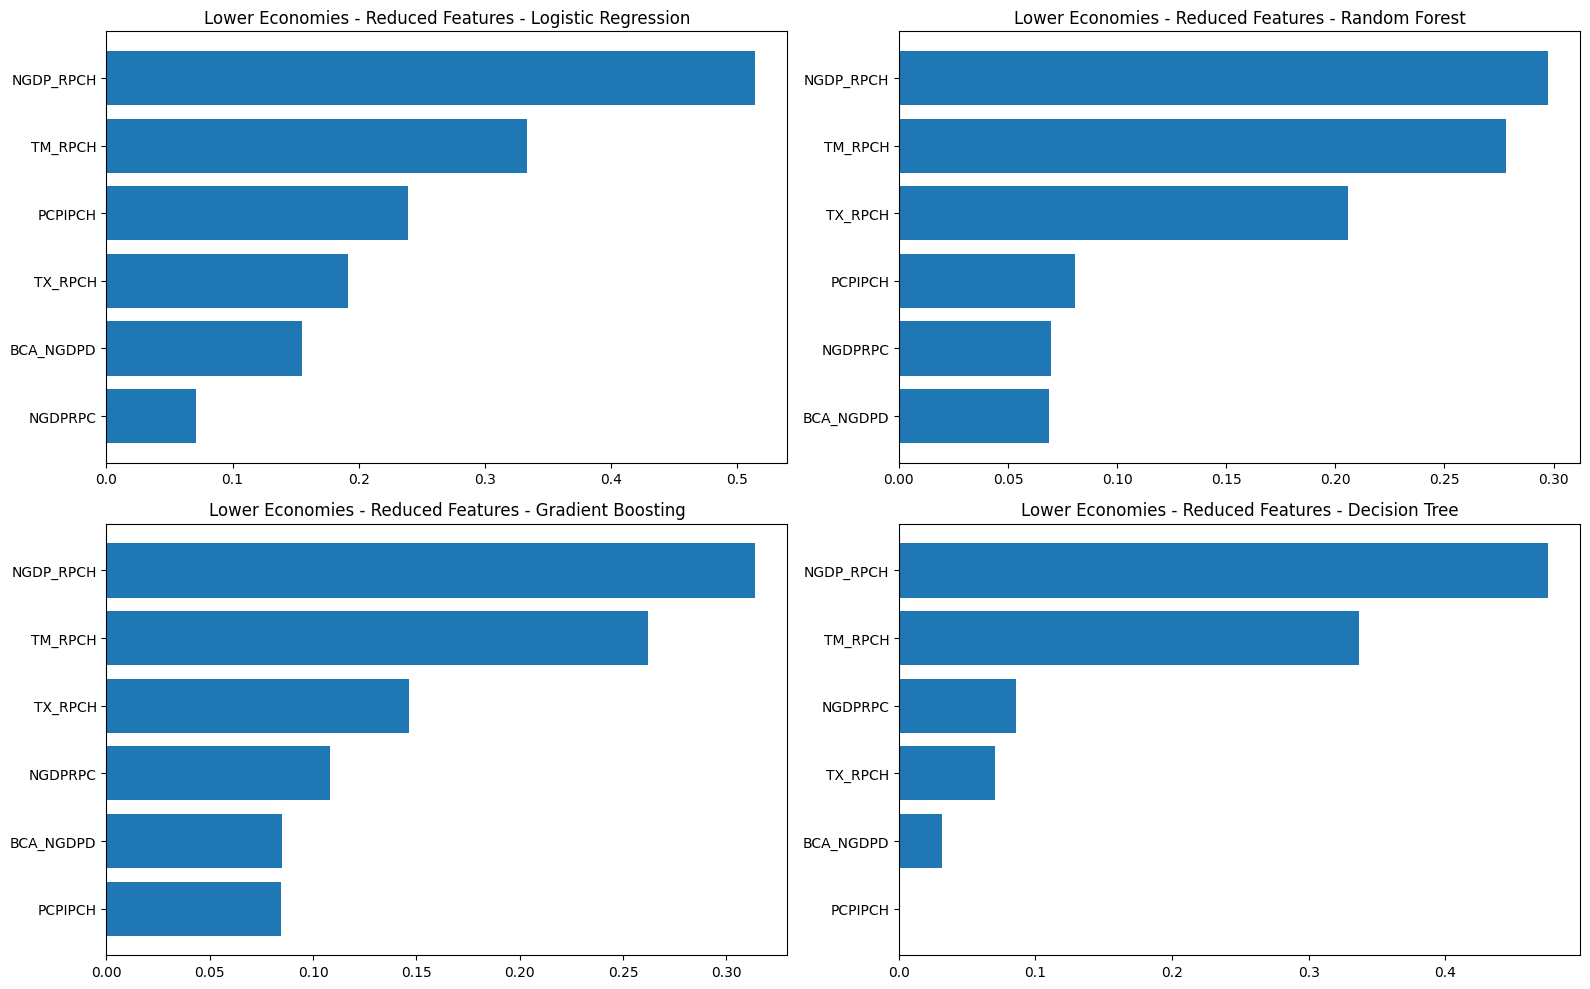

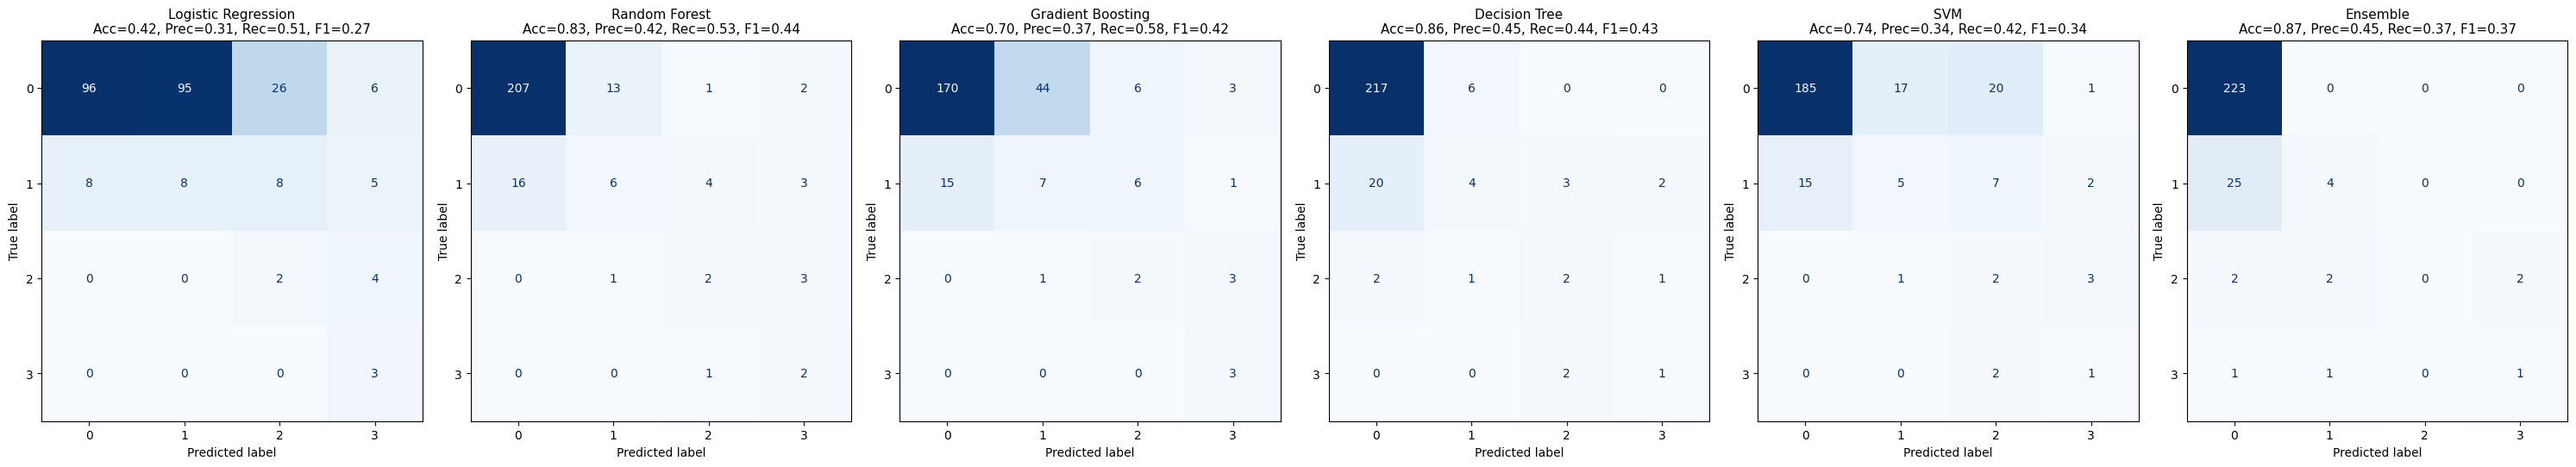

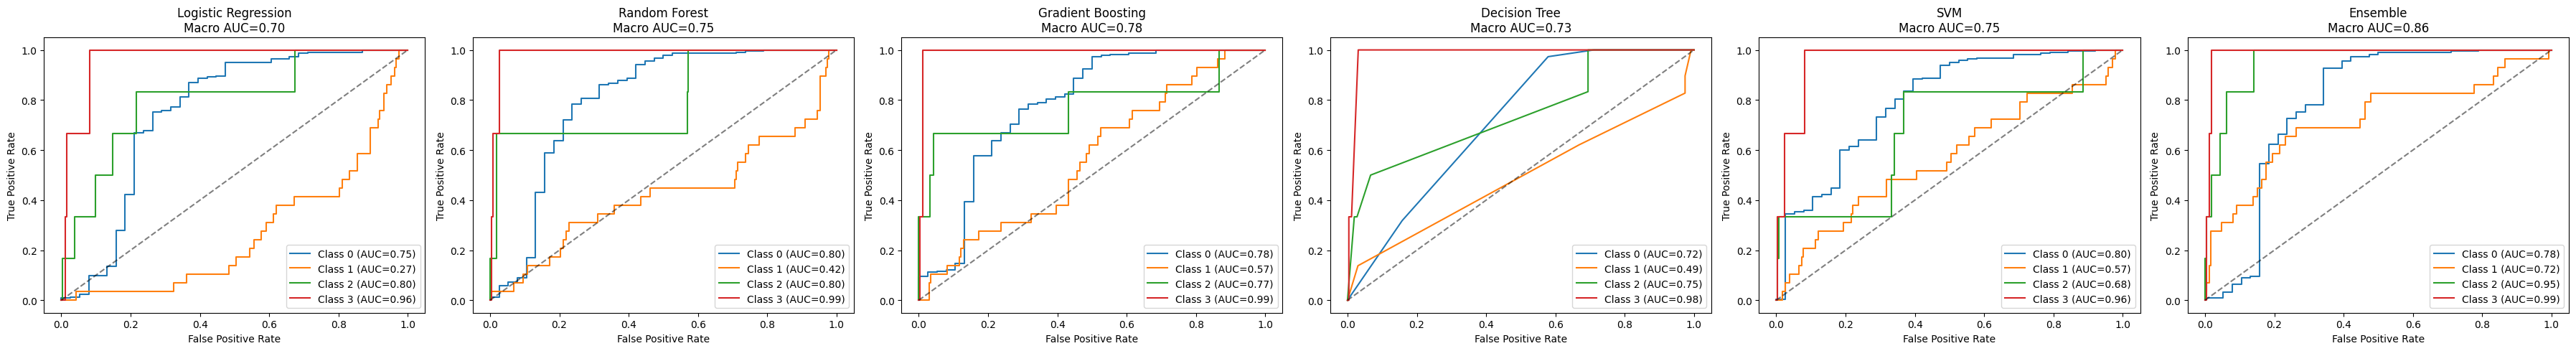

In [20]:
X_lower = df_Lower_Economies[selected_features]
y_lower = df_Lower_Economies["RecessionRisk"]

split_index_lower = int(len(X_lower) * 0.8)
X_train_lower = X_lower.iloc[:split_index_lower]
X_test_lower = X_lower.iloc[split_index_lower:]
y_train_lower = y_lower.iloc[:split_index_lower]
y_test_lower = y_lower.iloc[split_index_lower:]

# ✅ Unpack all three return values
models_lower_reduced, summary_df_lower_reduced, confusion_mats_lower_reduced = train_all_models(
    X_train_lower, y_train_lower, X_test_lower, y_test_lower
)

print("Lower Economies Accuracy (Reduced Features):")
print(summary_df_lower_reduced)

# Feature importance
plot_feature_importance(
    models_lower_reduced,
    feature_names=selected_features,
    title_prefix="Lower Economies - Reduced Features - "
)

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower_reduced, summary_df_lower_reduced)

# ✅ Show ROC curves + AUC for reduced-feature lower-economy models
show_roc_curves(models_lower_reduced, X_test_lower, y_test_lower)


# Prediction 2026-2030

In [21]:
df_predict = df_pivot.loc[df_pivot.index > 2025]
df_predict_original = df_predict.copy()
df_predict = df_predict.drop(columns=["RecessionRisk", "Country"])

df_predict_original['Continent'] = df_predict_original['Country'].astype(str).apply(country_to_continent)

continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_predict_original['EconomyGroup'] = df_predict_original['Continent'].map(continent_to_economy)

df_predict_lower = df_predict_original[df_predict_original['EconomyGroup'] == 'Lower_Economies']

df_predict_upper = df_predict_original[df_predict_original['EconomyGroup'] == 'Upper_Economies']

print("Created economy-specific prediction DataFrames from df_predict_original:")
print(f" - Lower_Economies predictions: {len(df_predict_lower)} rows")
print(f" - Upper_Economies predictions: {len(df_predict_upper)} rows")

Created economy-specific prediction DataFrames from df_predict_original:
 - Lower_Economies predictions: 190 rows
 - Upper_Economies predictions: 220 rows


In [22]:
# ============================================================
#                  PREDICTION FUNCTION (MULTICLASS)
# ============================================================
def make_predictions(models, df_predict):
    """
    Return multiclass predictions (0,1,2,3) from every model in one dataframe.
    """
    predictions = {}

    for name, model in models.items():
        # If model supports predict_proba → use argmax over classes
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(df_predict)
            predictions[name] = proba.argmax(axis=1)
        else:
            predictions[name] = model.predict(df_predict)

    return pd.DataFrame(predictions, index=df_predict.index)


# ============================================================
#      MULTICLASS RECESSION RISK COUNTS PER MODEL (PLOT)
# ============================================================
def plot_recession_counts_per_model(df_with_country, title):
    """
    Grouped bar plot per year per model:
    - X: Year
    - Bars: counts of each RecessionRisk class (0,1,2,3)
    - Facets: one subplot per model

    Expects df_with_country with columns:
        ['Year','Country', <model prediction columns>]
    where model columns contain multiclass predictions (0–3).
    """

    # Melt to long format
    df_long = df_with_country.melt(
        id_vars=['Year', 'Country'],
        var_name='Model',
        value_name='Prediction'
    )

    # Count per (Year, Model, Prediction)
    counts = (
        df_long.groupby(['Year', 'Model', 'Prediction'])
               .size()
               .reset_index(name='Count')
    )

    # Pivot → columns become risk classes (0,1,2,3)
    counts_pivot = (
        counts.pivot(index=['Year', 'Model'], columns='Prediction', values='Count')
              .fillna(0)
    ).reset_index()

    # Identify risk classes present
    risk_classes = sorted([c for c in counts_pivot.columns if isinstance(c, int)])

    # Reorder columns: Year, Model, then risk classes
    counts_pivot = counts_pivot[['Year', 'Model'] + risk_classes]

    # Plotting layout
    models = counts_pivot['Model'].unique()
    n_models = len(models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, model in enumerate(models):
        ax = axes[i]

        # Extract model-specific data
        mdf = counts_pivot[counts_pivot['Model'] == model].set_index('Year')[risk_classes]

        # Plot grouped bars
        plot = mdf.plot(kind='bar', ax=ax)

        ax.set_title(model)
        ax.set_ylabel('Number of countries')
        ax.set_xlabel('Year')
        ax.legend(title='RecessionRisk')

        # Annotate bars
        for p in plot.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(
                    f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=8, color='black', xytext=(0, 2),
                    textcoords='offset points'
                )

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()


In [23]:
df_predict_original.drop(columns=["RecessionRisk"], inplace=True)
df_predict_original

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Continent,EconomyGroup
Year,,,,,,,,,,,,,,,,
2026,Canada,-0.274,42.137,110.891,13.194,43.779,6.001410e+04,1.558,22.441,22.714,167.527,2.127,2.902,2.473,North_America,Upper_Economies
2026,Korea,3.630,22.994,55.731,10.264,23.444,4.544821e+07,1.447,35.269,31.639,118.373,1.800,2.158,1.916,Asia,Lower_Economies
2026,Chile,-2.427,25.126,43.415,27.334,26.215,1.076951e+07,2.182,21.232,23.661,148.028,3.172,2.881,2.992,South_America,Lower_Economies
2026,Sweden,6.020,47.462,33.859,13.131,48.211,6.066540e+05,2.168,31.413,25.394,134.347,2.000,2.895,2.593,Europe,Upper_Economies
2026,Albania,-3.050,27.898,53.500,46.714,30.450,8.226300e+05,3.468,22.120,26.460,133.147,2.665,3.294,6.092,Europe,Upper_Economies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,South_Africa,-2.191,27.585,88.732,87.354,33.225,7.391343e+04,1.812,11.975,14.166,128.458,4.500,3.308,3.405,Africa,Lower_Economies
2030,Spain,1.252,42.492,92.970,83.672,44.523,2.901847e+04,1.623,22.191,20.939,139.260,2.000,3.489,3.385,Europe,Upper_Economies
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,5.275161e+04,2.570,15.705,27.000,128.079,2.044,3.238,3.354,North_America,Upper_Economies


In [24]:
df_predict_upper.drop(columns=["RecessionRisk"], inplace=True)
df_predict_upper

C:\Users\ningw\AppData\Local\Temp\ipykernel_31508\311089533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_upper.drop(columns=["RecessionRisk"], inplace=True)


,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Continent,EconomyGroup
Year,,,,,,,,,,,,,,,,
2026,Canada,-0.274,42.137,110.891,13.194,43.779,60014.100,1.558,22.441,22.714,167.527,2.127,2.902,2.473,North_America,Upper_Economies
2026,Sweden,6.020,47.462,33.859,13.131,48.211,606654.016,2.168,31.413,25.394,134.347,2.000,2.895,2.593,Europe,Upper_Economies
2026,Albania,-3.050,27.898,53.500,46.714,30.450,822629.982,3.468,22.120,26.460,133.147,2.665,3.294,6.092,Europe,Upper_Economies
2026,Estonia,-2.362,41.658,27.298,14.110,44.552,21599.371,1.825,25.475,27.837,170.405,3.871,1.374,1.571,Europe,Upper_Economies
2026,Portugal,1.546,43.931,87.939,84.261,43.820,23497.967,1.667,20.919,19.373,127.127,2.083,2.719,1.931,Europe,Upper_Economies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Slovenia,2.490,44.602,63.768,48.605,47.129,25669.082,2.300,24.812,22.138,145.426,2.096,3.784,3.581,Europe,Upper_Economies
2030,Spain,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,Europe,Upper_Economies
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354,North_America,Upper_Economies


In [25]:
df_predict_lower.drop(columns=["RecessionRisk"], inplace=True)
df_predict_lower

C:\Users\ningw\AppData\Local\Temp\ipykernel_31508\1800171222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_lower.drop(columns=["RecessionRisk"], inplace=True)


,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Continent,EconomyGroup
Year,,,,,,,,,,,,,,,,
2026,Korea,3.630,22.994,55.731,10.264,23.444,4.544821e+07,1.447,35.269,31.639,118.373,1.800,2.158,1.916,Asia,Lower_Economies
2026,Chile,-2.427,25.126,43.415,27.334,26.215,1.076951e+07,2.182,21.232,23.661,148.028,3.172,2.881,2.992,South_America,Lower_Economies
2026,Islamic_Republic_of_Iran,1.301,9.559,41.871,38.402,14.946,1.973207e+08,1.104,38.754,37.453,555.347,42.500,-2.078,7.205,Asia,Lower_Economies
2026,Israel,2.912,35.767,69.341,67.526,40.152,1.696381e+05,3.600,28.135,25.223,104.744,1.982,3.612,3.173,Asia,Lower_Economies
2026,Eswatini,-2.905,26.246,39.018,35.553,30.750,4.690325e+04,4.931,11.543,14.448,456.673,4.819,3.133,3.140,Africa,Lower_Economies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Paraguay,-1.163,19.295,39.385,37.059,20.810,3.933554e+07,3.500,20.677,21.840,164.000,3.500,2.588,2.912,South_America,Lower_Economies
2030,Peru,-1.463,20.062,35.957,26.375,21.038,1.882146e+04,2.496,18.336,19.799,127.554,2.000,3.338,1.945,South_America,Lower_Economies
2030,Saudi_Arabia,-3.431,26.860,45.915,36.056,29.948,1.075253e+05,3.282,29.059,32.491,125.334,2.000,3.358,3.316,Asia,Lower_Economies


In [26]:
df_predict_upper_copy = df_predict_upper.copy()
df_predict_lower_copy = df_predict_lower.copy()
df_predict_upper_copy.drop(columns=['Continent', 'EconomyGroup', 'Country'], inplace=True)
df_predict_lower_copy.drop(columns=['Continent', 'EconomyGroup', 'Country'], inplace=True)

In [27]:
# Reset index once for reuse (assumes Year is the index in df_predict_original)
df_predict_original_reset = df_predict_original.reset_index()
df_predict_upper = df_predict_upper.reset_index()
df_predict_lower = df_predict_lower.reset_index()

   Year  Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026   Canada                    1              0                  0   
1  2026    Korea                    1              0                  1   
2  2026    Chile                    1              0                  1   
3  2026   Sweden                    0              0                  0   
4  2026  Albania                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              1    0         0  
2              2    0         0  
3              0    0         0  
4              0    0         0  


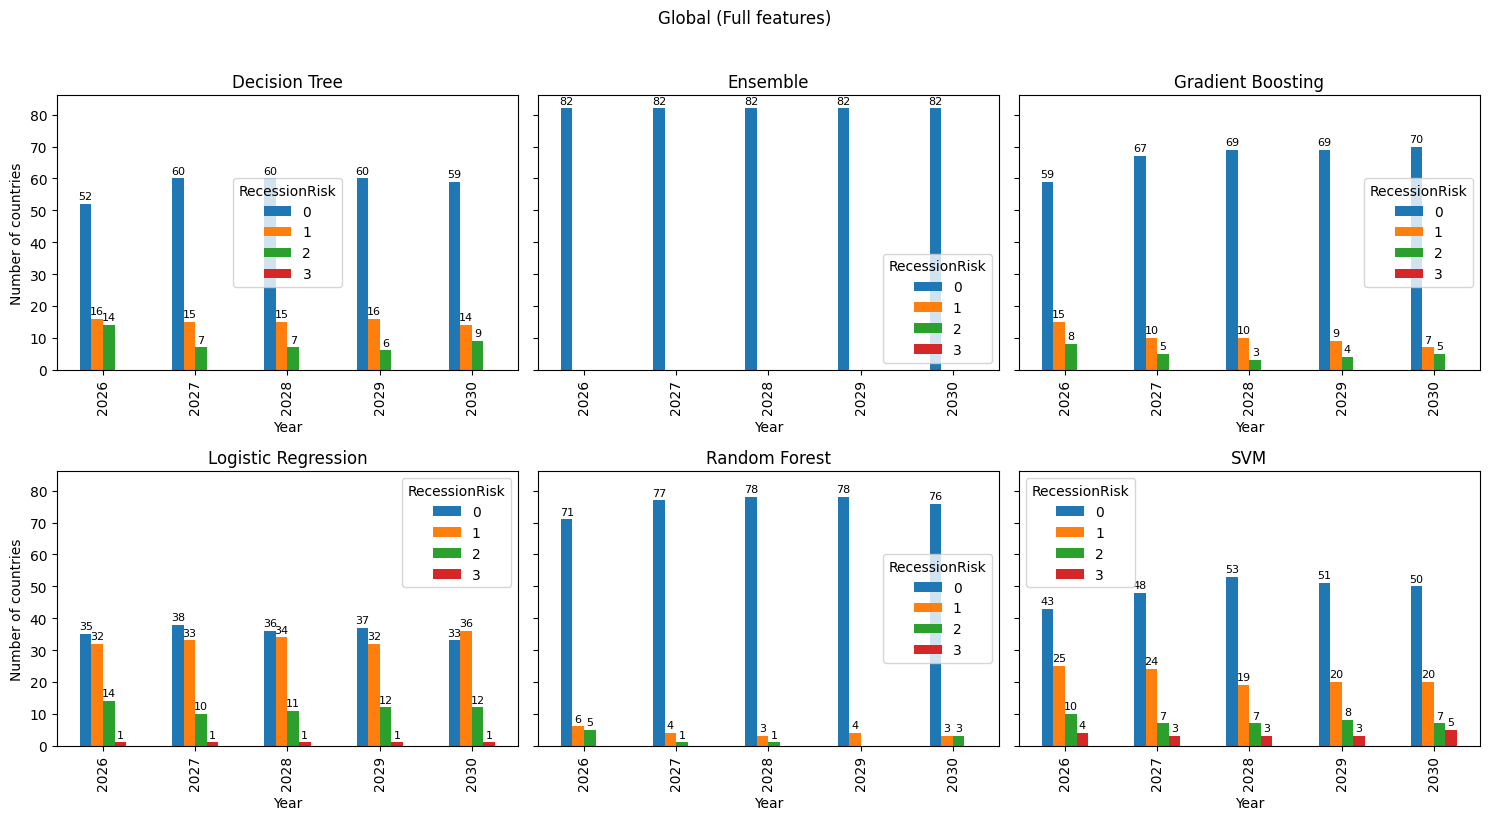

In [28]:
# ============================================================
# Global (all countries, full feature set)
# ============================================================
predictions = make_predictions(models, df_predict)
predictions_global_features_with_country = pd.concat(
    [df_predict_original_reset[['Year', 'Country']], predictions.reset_index(drop=True)],
    axis=1
)
print(predictions_global_features_with_country.head())
plot_recession_counts_per_model(predictions_global_features_with_country, "Global (Full features)")


   Year  Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026   Canada                    1              0                  0   
1  2026    Korea                    0              0                  0   
2  2026    Chile                    1              0                  1   
3  2026   Sweden                    0              0                  0   
4  2026  Albania                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              1    0         0  
2              2    0         0  
3              0    0         0  
4              0    0         0  


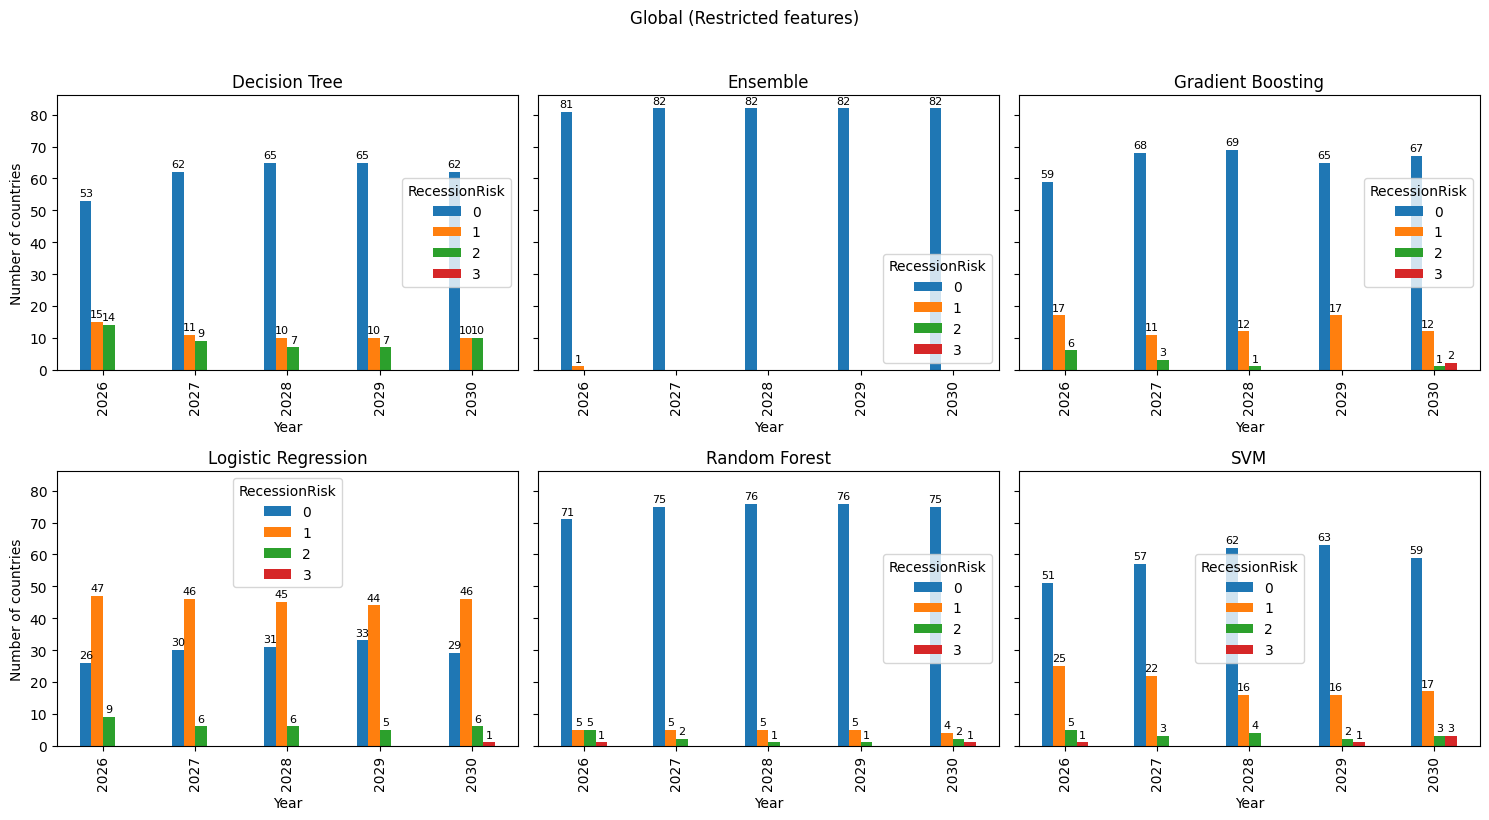

In [29]:
# ============================================================
# Global Restricted (all countries, restricted feature set)
# ============================================================
df_predict_restricted = df_predict[selected_features]
predictions_restricted_features = make_predictions(models_reduced, df_predict_restricted)
predictions_global_restricted_features_with_country = pd.concat(
    [df_predict_original_reset[['Year', 'Country']], predictions_restricted_features.reset_index(drop=True)],
    axis=1
)
print(predictions_global_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_global_restricted_features_with_country, "Global (Restricted features)")

   Year   Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026    Canada                    1              0                  0   
1  2026    Sweden                    0              0                  0   
2  2026   Albania                    1              0                  1   
3  2026   Estonia                    2              1                  1   
4  2026  Portugal                    0              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              0    0         0  
2              1    0         0  
3              1    2         0  
4              0    0         0  


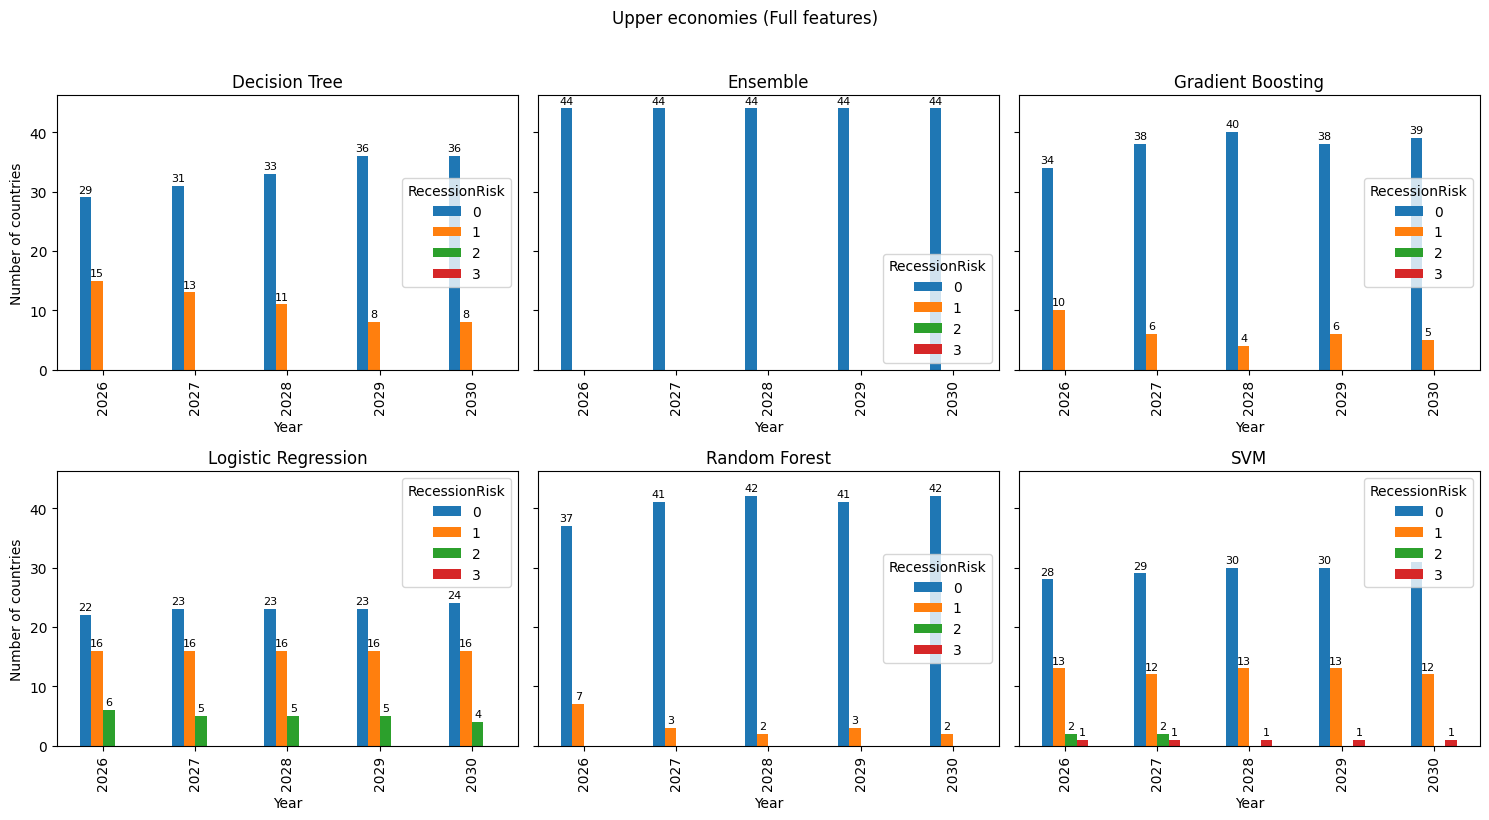

In [30]:

# ============================================================
# Upper Economies (full feature set)
# ============================================================
df_predict_upper_reset = df_predict_upper_copy.reset_index(drop=True)

X_predict_upper = df_predict_upper_reset.drop(columns=["RecessionRisk", "Country"], errors="ignore")
predictions_upper_features = make_predictions(models_upper, X_predict_upper)

predictions_upper_features_with_country = pd.concat(
    [df_predict_upper[["Year", "Country"]], predictions_upper_features.reset_index(drop=True)],
    axis=1
)

print(predictions_upper_features_with_country.head())
plot_recession_counts_per_model(predictions_upper_features_with_country, "Upper economies (Full features)")

   Year                   Country  Logistic Regression  Random Forest  \
0  2026                     Korea                    0              0   
1  2026                     Chile                    1              0   
2  2026  Islamic_Republic_of_Iran                    3              3   
3  2026                    Israel                    0              0   
4  2026                  Eswatini                    1              0   

   Gradient Boosting  Decision Tree  SVM  Ensemble  
0                  0              2    0         0  
1                  0              2    0         0  
2                  3              2    0         0  
3                  0              0    0         0  
4                  0              0    0         0  


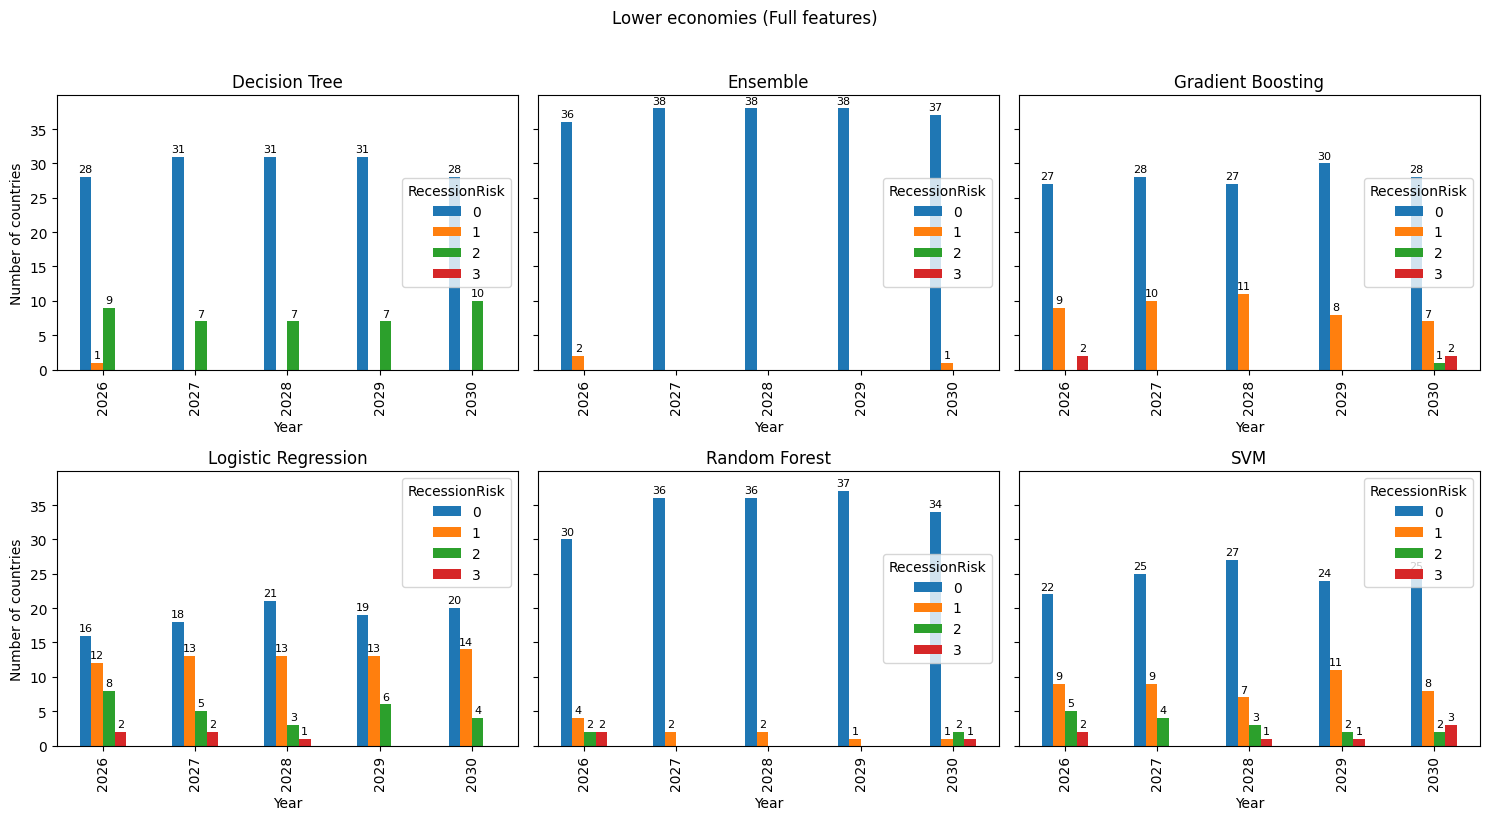

In [31]:
# ============================================================
# Lower Economies (full feature set)
# ============================================================
df_predict_lower_reset = df_predict_lower_copy.reset_index(drop=True)

X_predict_lower = df_predict_lower_reset.drop(columns=["RecessionRisk", "Country"], errors="ignore")
predictions_lower_features = make_predictions(models_lower, X_predict_lower)

predictions_lower_features_with_country = pd.concat(
    [df_predict_lower[["Year", "Country"]], predictions_lower_features.reset_index(drop=True)],
    axis=1
)

print(predictions_lower_features_with_country.head())
plot_recession_counts_per_model(predictions_lower_features_with_country, "Lower economies (Full features)")

   Year   Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026    Canada                    1              0                  0   
1  2026    Sweden                    1              0                  0   
2  2026   Albania                    1              0                  0   
3  2026   Estonia                    1              1                  1   
4  2026  Portugal                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              0    1         0  
2              1    0         0  
3              1    1         0  
4              0    0         0  


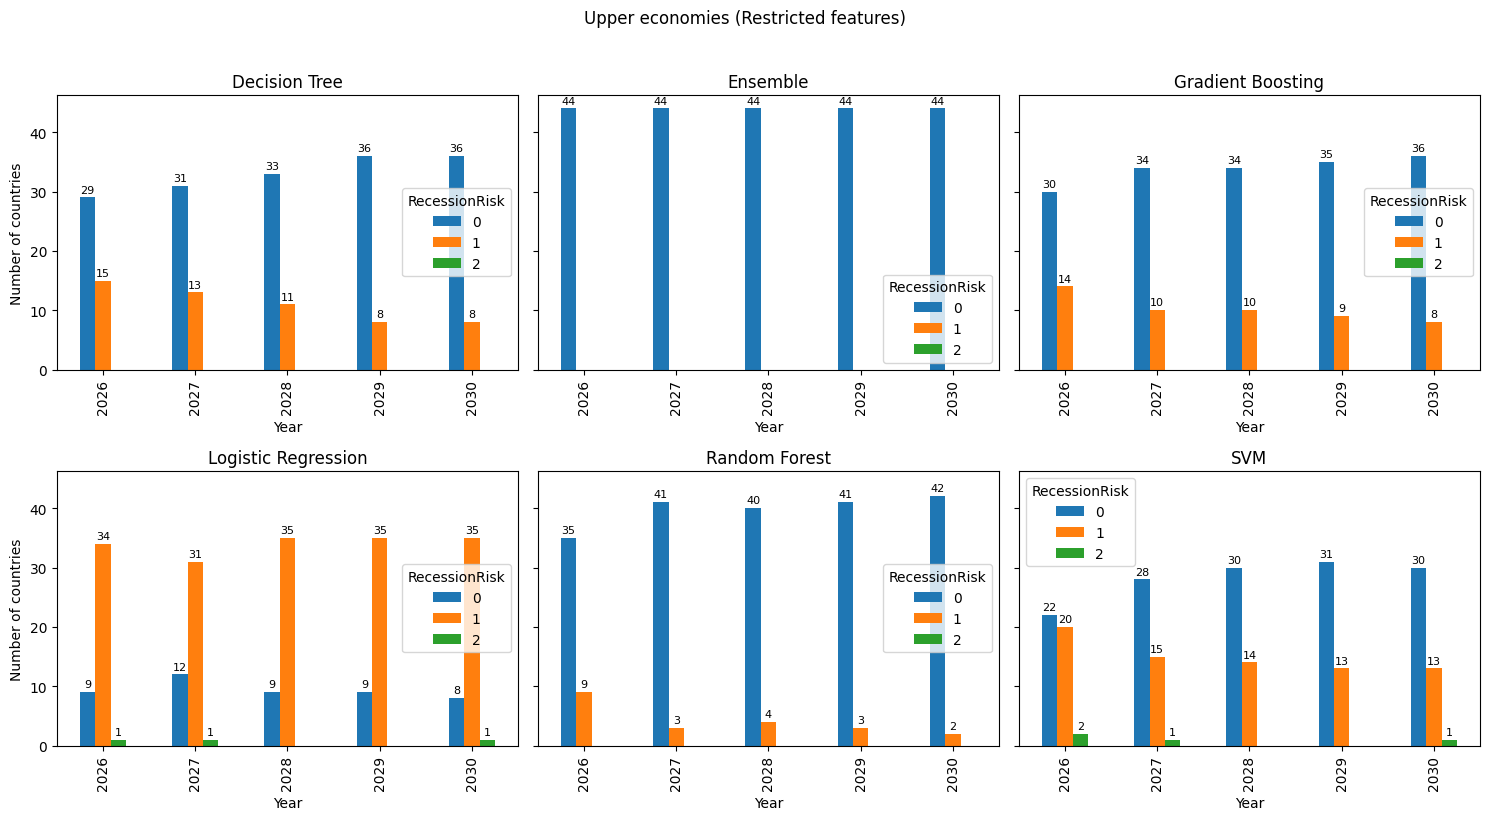

In [32]:
# ============================================================
# Upper Economies (restricted feature set)
# ============================================================
X_predict_upper_reduced = df_predict_upper[selected_features]
df_predict_upper_reset = df_predict_upper_copy.reset_index(drop=True)

X_predict_upper_reduced = df_predict_upper_reset[selected_features]
predictions_upper_restricted_features = make_predictions(models_upper_reduced, X_predict_upper_reduced)

predictions_upper_restricted_features_with_country = pd.concat(
    [df_predict_upper[["Year", "Country"]], predictions_upper_restricted_features.reset_index(drop=True)],
    axis=1
)

print(predictions_upper_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_upper_restricted_features_with_country, "Upper economies (Restricted features)")

   Year                   Country  Logistic Regression  Random Forest  \
0  2026                     Korea                    0              0   
1  2026                     Chile                    1              0   
2  2026  Islamic_Republic_of_Iran                    3              3   
3  2026                    Israel                    0              0   
4  2026                  Eswatini                    1              0   

   Gradient Boosting  Decision Tree  SVM  Ensemble  
0                  0              0    0         0  
1                  0              0    0         0  
2                  3              1    0         0  
3                  0              0    0         0  
4                  0              0    0         0  


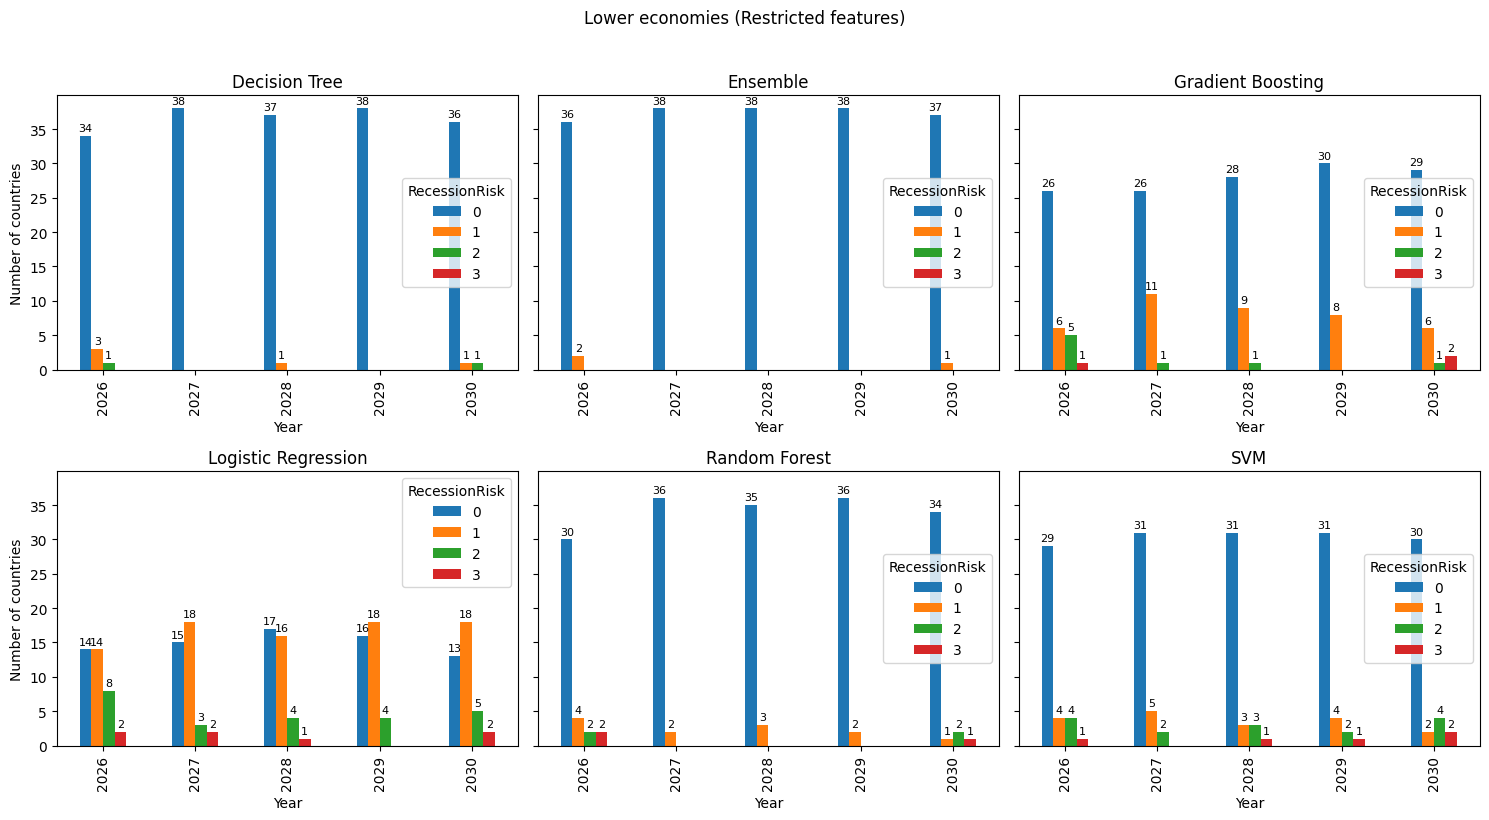

In [33]:
# ============================================================
# Lower Economies (restricted feature set)
# ============================================================
X_predict_lower_reduced = df_predict_lower[selected_features]
df_predict_lower_reset = df_predict_lower_copy.reset_index(drop=True)
X_predict_lower_reduced = df_predict_lower_reset[selected_features]
predictions_lower_restricted_features = make_predictions(models_lower_reduced, X_predict_lower_reduced)

predictions_lower_restricted_features_with_country = pd.concat(
    [df_predict_lower[["Year", "Country"]], predictions_lower_restricted_features.reset_index(drop=True)],
    axis=1
)

print(predictions_lower_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_lower_restricted_features_with_country, "Lower economies (Restricted features)")

# LTSM Neural Networks

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Core layers
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    GRU,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    Bidirectional
)

# Advanced sequence layers
from tensorflow.keras.layers import (
    Conv1D,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    MultiHeadAttention
)

# Model utilities
from tensorflow.keras.models import Sequential, Model

# Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

# Optimizers
from tensorflow.keras.optimizers import Adam, RMSprop

# Losses & metrics
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


In [36]:
df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,21732.461,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2341283.427,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,18811.646,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,529775.630,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,36526.988,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,South_Africa,-2.191,27.585,88.732,87.354,33.225,73913.430,1.812,11.975,14.166,128.458,4.500,3.308,3.405,0
2030,Spain,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,0
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354,0


In [37]:
def reshape_for_lstm(df, window=5):
    """
    Convert df_pivot (Year index, Country column) into LSTM-ready sequences.
    Returns:
        X_seq: (num_sequences, window, num_features)
        y_seq: (num_sequences,)
        countries_seq: country for each sequence
        years_seq: ending year for each sequence
    """

    df = df.copy()
    df = df.sort_values(["Country", df.index.name])  # sort by country + year

    # All columns except target + Country are features
    feature_cols = [c for c in df.columns if c not in ["RecessionRisk", "Country"]]

    X_seq = []
    y_seq = []
    countries_seq = []
    years_seq = []

    # Group by country
    for country, group in df.groupby("Country"):
        group = group.sort_index()  # ensure chronological order

        X_values = group[feature_cols].values
        y_values = group["RecessionRisk"].values
        years = group.index.values

        # Sliding window
        for i in range(len(group) - window):
            X_seq.append(X_values[i:i+window])
            y_seq.append(y_values[i+window])  # predict next year
            countries_seq.append(country)
            years_seq.append(years[i+window])

    return (
        np.array(X_seq),
        np.array(y_seq),
        np.array(countries_seq),
        np.array(years_seq)
    )


In [38]:
WINDOW = 5

X_seq, y_seq, countries_seq, years_seq = reshape_for_lstm(df_pivot, window=WINDOW)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)
print("Example sequence shape:", X_seq[0].shape)


X_seq shape: (2446, 5, 13)
y_seq shape: (2446,)
Example sequence shape: (5, 13)


In [39]:
test_years = np.arange(2026, 2031)  # 2026–2030 inclusive

test_mask = np.isin(years_seq, test_years)
train_mask = ~test_mask

X_train, X_test = X_seq[train_mask], X_seq[test_mask]
y_train, y_test = y_seq[train_mask], y_seq[test_mask]

countries_train = countries_seq[train_mask]
countries_test = countries_seq[test_mask]

years_train = years_seq[train_mask]
years_test = years_seq[test_mask]


In [ ]:
print("Train sequences:", X_train.shape)
print("Test sequences:", X_test.shape)

print("Train years range:", years_train.min(), "→", years_train.max())
print("Test years range:", years_test.min(), "→", years_test.max())

for i in range(3):
    print(f"\n--- Sequence {i} ---")
    print("Country:", countries_seq[i])
    print(f"Window years: {years_seq[i] - WINDOW} → {years_seq[i] - 1}")
    print("Target year:", years_seq[i])
    print("Target y_seq[i]:", y_seq[i])

    # Extract the country and years for the window
    country = countries_seq[i]
    start_year = years_seq[i] - WINDOW
    end_year = years_seq[i] - 1

    # Pull the corresponding y-values (RecessionRisk) from df_pivot
    y_window = df_pivot.loc[start_year:end_year].query("Country == @country")["RecessionRisk"].values

    print("\nX_seq[i] shape:", X_seq[i].shape)
    print("First 2 timesteps of X:")
    print(X_seq[i][:2])

    print("\nCorresponding y window (input labels):")
    print(y_window)

    print("Target y (next year):", y_seq[i])



--- Sequence 0 ---
Country: Albania
Window years: 2011 → 2015
Target year: 2016
Target y_seq[i]: 0

X_seq[i] shape: (5, 13)
First 2 timesteps of X:
[[-1.27650000e+01  2.51080000e+01  5.87140000e+01  5.74740000e+01
   2.85830000e+01  4.85786968e+05  2.54500000e+00  2.00160000e+01
   3.64300000e+01  9.28920000e+01  3.44300000e+00  3.63900000e+00
   1.01300000e+00]
 [-1.00820000e+01  2.44970000e+01  6.14140000e+01  5.98650000e+01
   2.78970000e+01  4.93487450e+05  1.41800000e+00  1.94430000e+01
   3.25050000e+01  9.47830000e+01  2.03600000e+00 -7.60400000e+00
  -4.07000000e-01]]

Corresponding y window (input labels):
[0 2 2 1 0]
Target y (next year): 0

--- Sequence 1 ---
Country: Albania
Window years: 2012 → 2016
Target year: 2017
Target y_seq[i]: 0

X_seq[i] shape: (5, 13)
First 2 timesteps of X:
[[-1.00820000e+01  2.44970000e+01  6.14140000e+01  5.98650000e+01
   2.78970000e+01  4.93487450e+05  1.41800000e+00  1.94430000e+01
   3.25050000e+01  9.47830000e+01  2.03600000e+00 -7.604000

In [43]:
model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW, X_seq.shape[2])),

    # LSTM layer
    keras.layers.LSTM(64, return_sequences=False),

    # Optional regularization
    keras.layers.Dropout(0.2),

    # Dense layers
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(4, activation="softmax")  # 4 recession-risk classes
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,180 (86.64 KB)

 Trainable params: 22,180 (86.64 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    shuffle=False,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5359 - loss: 1.1831 - val_accuracy: 0.9585 - val_loss: 0.5211
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6139 - loss: 1.0731 - val_accuracy: 0.9585 - val_loss: 0.5402
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6154 - loss: 1.0672 - val_accuracy: 0.9707 - val_loss: 0.5175
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6184 - loss: 1.0700 - val_accuracy: 0.9707 - val_loss: 0.5289
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6189 - loss: 1.0691 - val_accuracy: 0.9707 - val_loss: 0.5518
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6194 - loss: 1.0629 - val_accuracy: 0.9707 - val_loss: 0.5450
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6198 - loss: 1.0650 - val_accuracy: 0.9707 - val_loss: 0.5361
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6194 - loss: 1.0666 - val_accuracy: 0.9707 - val_loss: